In [176]:
# 1. Initial Setup
#    1.1 Import libraries
import pandas as pd
import numpy as np
import unicodedata
import re
from pathlib import Path
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MultiLabelBinarizer
# (prince, KMeans, silhouette_score, matplotlib will be used later)


In [177]:
#    1.2 Locate project root & raw data
project_root = Path.cwd().resolve().parents[1]
data_file    = project_root / "data" / "raw" / "03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx"
print("Project root:", project_root)
print("Data file:", data_file)

# load the actual responses
df_raw = pd.read_excel(data_file, sheet_name="Respuestas")
print("Raw shape:", df_raw.shape)
print(df_raw.columns.tolist())
print(df_raw.head())

Project root: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025
Data file: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025\data\raw\03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx
Raw shape: (487, 66)
['id', 'db', 'Marca temporal', 'Correo electrónico', 'Nombre de la empresa', 'Dirección de la empresa', 'Teléfono de contacto', 'Por favor indique el número de colaboradores que tiene su empresa o comercio', '¿En su empresa o comercio cuentan con colaboradoras mujeres?', 'Por favor indique el número de mujeres que trabajan en su empresa o comercio', 'Porcentaje mujeres', 'De sus empleadas mujeres, ¿Cuántas hacen parte de la cadena de distribución del negocio (conducen, reparten domicilios, acompañan las entregas, etc.)?', '% mujeres en la distribución', 'De las mujeres vinculadas a la cadena logística de su empresa o comercio ¿Cuántas están vinculadas por contrato laboral?', '% mujeres vincul

In [178]:

# 2. Load & Rename Raw Survey
#    2.1 Read Excel, strip whitespace, lowercase headers, parse timestamps
def dataframe_cleaning(path):
    df = pd.read_excel(path)
    df.columns = df.columns.str.strip().str.lower()
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    if 'marca temporal' in df.columns:
        df['marca temporal'] = pd.to_datetime(df['marca temporal'], errors='coerce')
    df = df.drop_duplicates()

    #    2.2 Drop non‐informative Spanish‐named columns
    drop_cols = [
        # Database flag
        'db',
        # “Go to end of survey.”
        'ir al fin de la encuesta.',
        
        # “By type of load, select up to 3”
        'de acuerdo con el tipo de carga que distribuye su empresa, indique máximo 3 tipos en el siguiente listado:',
        # Origin in Valle de Aburrá?
        '¿el origen de la mercancía que transporta es el valle de aburrá?',
        # Municipality of origin
        'por favor, indique el municipio:',
        # Daily deliveries to downtown Medellín
        'por favor, indique cuántas entregas hace en el centro de medellín al día:',
        # Daily number of establishments served downtown
        'por favor, indique el número de establecimientos que surte en el centro de medellín a diario:',
        # Daily orders received for downtown
        '¿cuántos pedidos recibe su empresa diariamente que tienen como destino el centro de medellín?',
        # Fleet composition by fuel type
        'por favor indique la cantidad de vehículos con combustión a diésel (acpm) con los que cuenta su empresa:',
        'por favor indique la cantidad de vehículos con combustión a gasolina con los que cuenta su empresa:',
        'por favor indique la cantidad de vehículos con combustión a gas natural vehicular (gnv) con los que cuenta su empresa:',
        'por favor indique la cantidad de vehículos con motor eléctrico con los que cuenta su empresa:',
        # Vehicle age ranges
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos anteriores a 1990]',
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos entre 1991 y 2000]',
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos entre 2001 y 2010]',
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos entre 2011 y 2015]',
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos del 2016 en adelante]',
        # Fuel/energy economy metrics
        '¿cuánto es el rendimiento en galones/kilómetro, de sus vehículos a acpm?',
        '¿cuánto es el rendimiento en galones/kilómetro, de sus vehículos a gasolina?',
        '¿cuánto es el rendimiento en metros cúbicos/kilómetro, de sus vehículos a gnv?',
        '¿cuánto es el rendimiento kilowatt-hora, de sus vehículos eléctricos?',
        # Cost and driver-hours metrics
        '¿cuánto es el costo total por movilizar un camión cargado hacia el centro de medellín?',
        '¿cuántas horas al volante permanece durante un turno de reparto una/un conductora/or en su empresa?',
        # Driver‐road‐user relationship (1=very complex…5=very adequate)
        'de acuerdo con la siguiente escala, donde 1 es "muy compleja" y 5 es "muy adecuada" ¿cómo considera la relación de sus conductores con los demás actores viales (peatones, ciclistas, conductores, transporte público) en el espacio público de la zuap?',
        # In‐company physical‐activity programs
        '¿al interior de su empresa se realizan actividades que promuevan la actividad física entre sus calaboradoras/es?',
        '¿qué actividades se realizan?',
        '¿cuántas veces por semana se realizan actividades para promover la actividad física?',
        # Awareness of Yellow Zone decree
        '¿conoce usted el decreto no 1790 de noviembre 20 de 2012 (decreto de zona amarilla o de cargue y descargue en el centro de la ciudad)?'
    ]
    df = df.drop(columns=drop_cols, errors='ignore')

    #    2.3 Rename remaining to concise English
    rename_map = {
        'marca temporal': 'timestamp',
        'nombre de la empresa': 'company_name',
        'correo electrónico': 'email',
        'dirección de la empresa': 'est_address',
        'teléfono de contacto': 'contact_phone',
        'por favor indique el número de colaboradores que tiene su empresa o comercio': 'employees',
        '¿en su empresa o comercio cuentan con colaboradoras mujeres?': 'has_female_employees',
        'por favor indique el número de mujeres que trabajan en su empresa o comercio': 'female_employees',
        'porcentaje mujeres': 'female_percentage',
        'de sus empleadas mujeres, ¿cuántas hacen parte de la cadena de distribución del negocio (conducen, reparten domicilios, acompañan las entregas, etc.)?': 'female_in_distribution',
        '% mujeres en la distribución': 'pct_female_in_distribution',
        'de las mujeres vinculadas a la cadena logística de su empresa o comercio ¿cuántas están vinculadas por contrato laboral?': 'female_with_contract',
        '% mujeres vinculadas': 'pct_female_with_contract',
        'entre sus colaboradoras mujeres, alguna(s) se identifica(n) con los siguientes grupos poblacionales:': 'female_population_groups',
        '¿acompañan y/o apoyan el proceso formativo de las mujeres que hacen parte de la cadena logística?': 'female_support_roles',
        'por favor, indique dentro de la siguientes categorías, cuál se relaciona con la actividad realizada en su comercio:': 'economic_activity',
        'de acuerdo al listado señale en orden de importancia las 3 principales actividades comerciales que se desarrollan en su establecimiento:': 'top_3_activities',
        'productos principales': 'main_products',
        '¿su establecimiento cuenta con espacio de bodega o almacenamiento de mercancías o productos?': 'has_warehouse_space',
        '¿con cuántos espacios de bodega cuenta?': 'warehouse_count',
        '¿en qué piso se ubica(n) la(s) bodegas que sirven a su empresa o comercio?': 'warehouse_floor',
        'por favor, indique el área de la bodega que sirve a su comercio en metros cuadrados:': 'warehouse_area_m2',
        'por favor, indique la altura en metros de la bodega que sirve a su comercio:': 'warehouse_height_m',
        '¿el(los) espacio(s) de bodega están ubicados al interior de la zuap?': 'warehouse_within_zuap',
        '¿en qué municipio se encuentra ubicada la bodega que sirve a su comercio?': 'warehouse_municipality',
        'por favor, indique el tipo de bodega con la que cuenta:': 'warehouse_type',
        'por favor, seleccione los días en los cuales recibe materiales, materias primas o productos:': 'supply_day',
        '¿cuántas veces por semana abastece su establecimiento?': 'supply_frequency_per_week',
        'por favor, indique los horarios durante los cuales realiza las actividades de cargue y descargue de las mercancías:': 'loading_schedule',
        'por favor, indique la forma en la que ingresa la mercancía a su comercio o área de bodega:': 'unloading_method',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en camión, carro o motocicleta es?': 'safety_perception_motorized',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en bicicleta es?': 'safety_perception_bicycle',
        '¿el establecimiento o bodega posee alguno de los siguientes elementos para el cargue y descargue de mercancías?': 'loading_equipment',
        '¿qué medio realiza para el envío de sus artículos a domicilio?': 'delivery_modes',
        '¿cuántos domicilios realiza a diario su establecimiento?': 'daily_delivery_count',
        '¿qué medio realiza para el envío de sus ventas por internet?': 'online_delivery_modes',
        '¿cuántos envíos de artículos vendidos por internet realiza a diario su establecimiento?': 'daily_online_delivery_count'
    }
    return df.rename(columns=rename_map)

In [212]:

df_clean = dataframe_cleaning(data_file)
print("df_clean shape:", df_clean.shape)
print(df_clean.columns.tolist())
print(df_clean.head())
print("original info:", df_clean.info())


df_clean shape: (487, 38)
['id', 'timestamp', 'email', 'company_name', 'est_address', 'contact_phone', 'employees', 'has_female_employees', 'female_employees', 'female_percentage', 'female_in_distribution', 'pct_female_in_distribution', 'female_with_contract', 'pct_female_with_contract', 'female_population_groups', 'female_support_roles', 'economic_activity', 'top_3_activities', 'main_products', 'has_warehouse_space', 'warehouse_count', 'warehouse_floor', 'warehouse_area_m2', 'warehouse_height_m', 'warehouse_within_zuap', 'warehouse_municipality', 'warehouse_type', 'supply_day', 'supply_frequency_per_week', 'loading_schedule', 'unloading_method', 'safety_perception_motorized', 'safety_perception_bicycle', 'loading_equipment', 'delivery_modes', 'daily_delivery_count', 'online_delivery_modes', 'daily_online_delivery_count']
   id               timestamp                                     email  \
0   1 2022-05-17 11:20:36.160      Gestiohumana@111tiendasdebelleza.com   
1   2 2022-05-18

C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\3617814660.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [180]:
#check repeated results in columns
print("Checking unique values in each column:")
for col in df_clean.columns[6:]:
    if col in df_clean.columns:
        uniques = df_clean[col].unique()
        print(f"{col} ({len(uniques)} unique):")
        print(uniques)
        print("-" * 40)
    else:
        print(f"{col}: [Column not found in df_clean]")
        print("-" * 40)

Checking unique values in each column:
employees (36 unique):
[ 13  12   3  32   4   6   2  14  18   5   7   9   1   8  20  39  11  10
  24  19 150  27  15  17  30 105  25 153  47  28  26  60  53  48  23  16]
----------------------------------------
has_female_employees (2 unique):
['Sí' 'No']
----------------------------------------
female_employees (27 unique):
[  5.   9.  nan  20.   1.   2.   3.   7.  15.   6.   4.   8.  21.  26.
  23.  10.  13.  72. 105.  22.  16.  11.  14.  32.  34.  12.  25.]
----------------------------------------
female_percentage (68 unique):
[0.38461538 0.75       0.         0.625      0.25       0.33333333
 0.5        0.07142857 0.27777778 1.         0.71428571 0.4
 0.53846154 0.11111111 0.35       0.66666667 0.54545455 0.45454545
 0.1        0.8        0.6        0.2        0.875      0.16666667
 0.125      0.83333333 0.81818182 0.42105263 0.17333333 0.74074074
 0.7        0.42857143 0.44444444 0.35294118 0.22222222 0.55555556
 0.63636364 0.76666667 0.9285

In [181]:
# 3. Initial Type Adjustment
#    3.1 Single‐label categorical → category
categorical__nominal_cols = [
    "main_products", "has_warehouse_space", "warehouse_within_zuap",
    "warehouse_municipality", "warehouse_type", "economic_activity","female_support_roles"
]
for col in categorical__nominal_cols:
    df_clean[col] = df_clean[col].astype("category")

#    3.2 Multi‐label text fields → string (to explode later)
multi_col_text = ["top_3_activities","supply_day","loading_schedule",
              "unloading_method","loading_equipment",
              "delivery_modes","online_delivery_modes","female_population_groups"]
for col in multi_col_text:
    df_clean[col] = df_clean[col].astype(str)

#    3.3 Ordinal factors
#        3.3.1 Floors as ordered categories
floor_cats = sorted(df_clean["warehouse_floor"].dropna().unique(), key=float)
df_clean["warehouse_floor"] = df_clean["warehouse_floor"]\
    .astype(CategoricalDtype(categories=floor_cats, ordered=True))
#        3.3.2 Likert scales 1–5
likert = CategoricalDtype(categories=[1,2,3,4,5], ordered=True)
for col in ["safety_perception_motorized","safety_perception_bicycle"]:
    df_clean[col] = df_clean[col].astype(likert)

#    3.4 Numeric counts & measures
num_cols = ["warehouse_count","warehouse_area_m2","warehouse_height_m",
            "daily_delivery_count","daily_online_delivery_count",
            "employees","female_employees",
            "female_in_distribution","female_with_contract"]
for col in num_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

#    3.5 Percentages → float
for col in ["female_percentage","pct_female_in_distribution","pct_female_with_contract"]:
    df_clean[col] = df_clean[col].astype(float)

#    3.6 Supply frequency → extract numeric & ordered
freq_map = {
    "1 vez por semana":1, "2":2, "5":5, "6 o más":6,
    "La periodicidad es quincenal":2, "La periodicidad es mensual":1
}
df_clean["supply_frequency_num"] = (
    df_clean["supply_frequency_per_week"]
      .map(freq_map).fillna(0).astype(int)
      .astype(CategoricalDtype(categories=[1,2,5,6], ordered=True))
)

#    3.7 Remaining text as category
descriptive_cols = ["email", "company_name", "est_address", "contact_phone"]

for col in descriptive_cols:
    df_clean[col] = df_clean[col].astype("category")


In [182]:
print("df_clean shape:", df_clean.shape)
print(df_clean.columns.tolist())
print(df_clean.head())
print("New df info:", df_clean.info())

df_clean shape: (487, 39)
['id', 'timestamp', 'email', 'company_name', 'est_address', 'contact_phone', 'employees', 'has_female_employees', 'female_employees', 'female_percentage', 'female_in_distribution', 'pct_female_in_distribution', 'female_with_contract', 'pct_female_with_contract', 'female_population_groups', 'female_support_roles', 'economic_activity', 'top_3_activities', 'main_products', 'has_warehouse_space', 'warehouse_count', 'warehouse_floor', 'warehouse_area_m2', 'warehouse_height_m', 'warehouse_within_zuap', 'warehouse_municipality', 'warehouse_type', 'supply_day', 'supply_frequency_per_week', 'loading_schedule', 'unloading_method', 'safety_perception_motorized', 'safety_perception_bicycle', 'loading_equipment', 'delivery_modes', 'daily_delivery_count', 'online_delivery_modes', 'daily_online_delivery_count', 'supply_frequency_num']
   id               timestamp                                     email  \
0   1 2022-05-17 11:20:36.160      Gestiohumana@111tiendasdebelleza

In [162]:
# Check new unique values in each column from the 6th column onward
print("\nUnique values in each column (from index 6):")
for col in df_clean.columns[6:]:
    uniques = df_clean[col].dropna().unique()
    print(f"{col} ({len(uniques)} unique):")
    print(uniques)
    print("-" * 40)


Unique values in each column (from index 6):
employees (36 unique):
[ 13  12   3  32   4   6   2  14  18   5   7   9   1   8  20  39  11  10
  24  19 150  27  15  17  30 105  25 153  47  28  26  60  53  48  23  16]
----------------------------------------
has_female_employees (2 unique):
['Sí' 'No']
----------------------------------------
female_employees (26 unique):
[  5.   9.  20.   1.   2.   3.   7.  15.   6.   4.   8.  21.  26.  23.
  10.  13.  72. 105.  22.  16.  11.  14.  32.  34.  12.  25.]
----------------------------------------
female_percentage (68 unique):
[0.38461538 0.75       0.         0.625      0.25       0.33333333
 0.5        0.07142857 0.27777778 1.         0.71428571 0.4
 0.53846154 0.11111111 0.35       0.66666667 0.54545455 0.45454545
 0.1        0.8        0.6        0.2        0.875      0.16666667
 0.125      0.83333333 0.81818182 0.42105263 0.17333333 0.74074074
 0.7        0.42857143 0.44444444 0.35294118 0.22222222 0.55555556
 0.63636364 0.76666667 0.92

In [184]:
# 4. Normalize & Translate Text
#    4.1 Helper: lowercase, strip accents
def normalize_text(s):
    if pd.isna(s): 
        return s
    return unicodedata.normalize("NFKD", str(s))\
                      .encode("ascii","ignore").decode()\
                      .lower().strip()

In [185]:
#    4.2 warehouse_within_zuap
YESNO = {"sí":"yes","si":"yes","no":"no","no aplica":pd.NA}

# Normalize and map warehouse_within_zuap values
df_clean["warehouse_within_zuap"] = (
    df_clean["warehouse_within_zuap"]
      .map(normalize_text)
      .replace(YESNO)
      .astype("category")
)

# Show unique values for verification
print("warehouse_within_zuap (unique):", df_clean["warehouse_within_zuap"].unique())


warehouse_within_zuap (unique): ['yes', NaN, 'no']
Categories (2, object): ['no', 'yes']


C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\2347308386.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace(YESNO)


In [186]:
# Clean main_products without collapsing to top-N: preserve each row’s unique value
df_clean["main_products"] = (
    df_clean["main_products"]
      .map(normalize_text)          # normalize case, remove accents, trim
      .astype("category")           # cast to categorical, retaining all unique levels
)

print("Normalized main_products (unique):", df_clean["main_products"].unique())

Normalized main_products (unique): ['cosmeticos y productos de belleza', 'calzado', 'reciclaje y residuos', 'manufacturas', 'mecanica', ..., 'productos carnicos', 'arte y materiales para el arte', 'bares y ocio', 'servicio de estacionamiento', 'suministros']
Length: 34
Categories (34, object): ['arte y materiales para el arte', 'articulos para el hogar', 'bares y ocio', 'cacao, chocolate y confiteria', ..., 'servicio de estacionamiento', 'servicios de telecomunicaciones', 'servicios financieros', 'suministros']


In [189]:
print(df_clean.head())

   id               timestamp                                     email  \
0   1 2022-05-17 11:20:36.160      Gestiohumana@111tiendasdebelleza.com   
1   2 2022-05-18 11:17:48.282   CalzadobucaramangaMedellín2@hotmail.com   
2   3 2022-05-18 08:28:01.487                                 No aplica   
3   4 2022-05-16 16:22:43.406  comercializadoracentermedmatur@gmail.com   
4   5 2022-05-16 15:54:14.360                       pipemotos@gmail.com   

                           company_name                est_address  \
0     Iversiones111t tiendas de belleza  CL 48 54 43 local 102 108   
1  Distri zapatos - calzado bucaramanga                 Cr 54 4803   
2                       Molina y arango            Calle 44a 54 32   
3               Comercializadora center             Calle 46 53 05   
4                            Pipe motos          Calle  45 53 A 12   

         contact_phone  employees has_female_employees  female_employees  \
0              5110950         13                   

In [190]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           487 non-null    int64         
 1   timestamp                    487 non-null    datetime64[ns]
 2   email                        474 non-null    category      
 3   company_name                 487 non-null    category      
 4   est_address                  487 non-null    category      
 5   contact_phone                487 non-null    category      
 6   employees                    487 non-null    int64         
 7   has_female_employees         487 non-null    object        
 8   female_employees             445 non-null    float64       
 9   female_percentage            487 non-null    float64       
 10  female_in_distribution       445 non-null    float64       
 11  pct_female_in_distribution   445 non-null    

In [195]:
# Main categories exactly as they appear in original data
main_cats = ["Venta al detalle", "Fabricante", "Proveedor", "Ventas por internet"]

def split_econ_preserve_caps(x):
    if pd.isna(x):
        return pd.Series([pd.NA, pd.NA, pd.NA])
    
    # Step 1: Find matching main category (case-sensitive match)
    main = next((m for m in main_cats if x.startswith(m)), None)
    if main is None:
        return pd.Series([x, pd.NA, pd.NA])  # fallback
    
    # Step 2: Strip out main part and work with the rest
    rest = x[len(main):].strip()
    if not rest:
        return pd.Series([main, pd.NA, pd.NA])
    
    # Step 3: Use regex to find segments that start with uppercase (incl. accents)
    parts = re.findall(r'([A-ZÁÉÍÓÚÑ][^A-ZÁÉÍÓÚÑ]*)', rest)
    sub1 = parts[0].strip() if len(parts) >= 1 else pd.NA
    sub2 = parts[1].strip() if len(parts) >= 2 else pd.NA
    
    return pd.Series([main, sub1, sub2])

# Apply the split (no normalization!)
import re
import pandas as pd

# ensure economic_activity is treated as plain strings for the split
econ_split = df_clean["economic_activity"].astype(str).apply(split_econ_preserve_caps)

df_clean[["econ_main", "econ_sub1", "econ_sub2"]] = econ_split

for col in ["econ_main", "econ_sub1", "econ_sub2"]:
    df_clean[col] = df_clean[col].astype("category")

# verify
print(df_clean[["economic_activity", "econ_main", "econ_sub1", "econ_sub2"]].head())


# Verify outcome
print(df_clean[["economic_activity", "econ_main", "econ_sub1", "econ_sub2"]].head())


                             economic_activity         econ_main  \
0                             Venta al detalle  Venta al detalle   
1                             Venta al detalle  Venta al detalle   
2                             Venta al detalle  Venta al detalle   
3  Fabricante Compran terminado y comercializa        Fabricante   
4                                    Proveedor         Proveedor   

                          econ_sub1 econ_sub2  
0                               NaN       NaN  
1                               NaN       NaN  
2                               NaN       NaN  
3  Compran terminado y comercializa       NaN  
4                               NaN       NaN  
                             economic_activity         econ_main  \
0                             Venta al detalle  Venta al detalle   
1                             Venta al detalle  Venta al detalle   
2                             Venta al detalle  Venta al detalle   
3  Fabricante Compran terminado

In [ ]:
# 5. Standardize has_warehouse_space levels
# has_warehouse_space (5 unique):
# ['Interno' 'No' 'Externo, propio' 'Externo, alquilado'
#  'Externo, compartido con otros comercios']
# ----------------------------------------
df_clean["has_warehouse_space"] = (
    df_clean["has_warehouse_space"]
      .map(normalize_text)
      .replace({
          "interno": "internal",
          "externo, propio": "external_own",
          "externo, alquilado": "external_rented",
          "externo, compartido con otros comercios": "external_shared",
          "no": "none"
      })
      .astype("category")
)

print

Normalized has_warehouse_space (unique): ['internal', 'none', 'external_own', 'external_rented', 'external_shared']
Categories (5, object): ['external_rented', 'external_shared', 'external_own', 'internal', 'none']


C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\2045504869.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace({


warehouse_within_zuap (unique): ['yes', NaN, 'no']
Categories (2, object): ['no', 'yes']
Normalized single-label columns:
main_products (34 unique):
['cosmeticos y productos de belleza' 'calzado' 'reciclaje y residuos'
 'manufacturas' 'mecanica' 'moda y textiles' 'mensajeria' 'ferreteria'
 'maderas' 'articulos para el hogar' 'electronica'
 'jugueteria y elementos deportivos' 'cacao, chocolate y confiteria'
 'productos medicos y de salud' 'cafe' 'restauracion' 'electrodomesticos'
 'papeleria' 'productos alimenticios' 'materiales de construccion'
 'productos veterinarios y mascotas' 'muebles de oficina' 'compraventa'
 'productos de aseo' 'joyas' 'servicios financieros' 'refrigeracion'
 'maquinaria' 'servicios de telecomunicaciones' 'productos carnicos'
 'arte y materiales para el arte' 'bares y ocio'
 'servicio de estacionamiento' 'suministros']
----------------------------------------
economic_activity (91 unique):
['venta al detalle' 'fabricante compran terminado y comercializa'
 'prov

In [209]:
print(df_clean.head())
print(df_clean.info())

   id               timestamp                                     email  \
0   1 2022-05-17 11:20:36.160      Gestiohumana@111tiendasdebelleza.com   
1   2 2022-05-18 11:17:48.282   CalzadobucaramangaMedellín2@hotmail.com   
2   3 2022-05-18 08:28:01.487                                 No aplica   
3   4 2022-05-16 16:22:43.406  comercializadoracentermedmatur@gmail.com   
4   5 2022-05-16 15:54:14.360                       pipemotos@gmail.com   

                           company_name                est_address  \
0     Iversiones111t tiendas de belleza  CL 48 54 43 local 102 108   
1  Distri zapatos - calzado bucaramanga                 Cr 54 4803   
2                       Molina y arango            Calle 44a 54 32   
3               Comercializadora center             Calle 46 53 05   
4                            Pipe motos          Calle  45 53 A 12   

         contact_phone  employees has_female_employees  female_employees  \
0              5110950         13                   

In [202]:
#check repeated results in columns
print("Checking unique values in each column:")
for col in df_clean.columns[6:]:
    if col in df_clean.columns:
        uniques = df_clean[col].unique()
        print(f"{col} ({len(uniques)} unique):")
        print(uniques)
        print("-" * 40)
    else:
        print(f"{col}: [Column not found in df_clean]")
        print("-" * 40)

Checking unique values in each column:
employees (36 unique):
[ 13  12   3  32   4   6   2  14  18   5   7   9   1   8  20  39  11  10
  24  19 150  27  15  17  30 105  25 153  47  28  26  60  53  48  23  16]
----------------------------------------
has_female_employees (2 unique):
['Sí' 'No']
----------------------------------------
female_employees (27 unique):
[  5.   9.  nan  20.   1.   2.   3.   7.  15.   6.   4.   8.  21.  26.
  23.  10.  13.  72. 105.  22.  16.  11.  14.  32.  34.  12.  25.]
----------------------------------------
female_percentage (68 unique):
[0.38461538 0.75       0.         0.625      0.25       0.33333333
 0.5        0.07142857 0.27777778 1.         0.71428571 0.4
 0.53846154 0.11111111 0.35       0.66666667 0.54545455 0.45454545
 0.1        0.8        0.6        0.2        0.875      0.16666667
 0.125      0.83333333 0.81818182 0.42105263 0.17333333 0.74074074
 0.7        0.42857143 0.44444444 0.35294118 0.22222222 0.55555556
 0.63636364 0.76666667 0.9285

In [210]:
import re
import unicodedata
import pandas as pd

# --- helpers ---
def strip_accents(text: str) -> str:
    if not isinstance(text, str):
        return text
    nfkd = unicodedata.normalize("NFKD", text)
    return "".join([c for c in nfkd if not unicodedata.combining(c)])

def normalize_text(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text)
    text = strip_accents(text)
    text = text.lower().strip()
    text = re.sub(r"\s+", " ", text)
    return text

# supply_day translation map
DAY_EN = {
    "lunes": "monday", "martes": "tuesday", "miercoles": "wednesday",
    "miércoles": "wednesday", "jueves": "thursday", "viernes": "friday",
    "sabado": "saturday", "sábado": "saturday", "domingo": "sunday",
    "festivos": "holidays",
}

def translate_supply_day(cell):
    if pd.isna(cell):
        return ""
    pieces = [p.strip() for p in re.split(r'\s*,\s*', strip_accents(str(cell)).lower()) if p.strip()]
    translated = []
    for p in pieces:
        translated.append(DAY_EN.get(p, p))
    # dedupe preserving order
    seen = set()
    out = []
    for t in translated:
        if t not in seen:
            seen.add(t)
            out.append(t)
    return ", ".join(out)

# --- start from existing df_clean ---
df_translated = df_clean.copy()

# econ_combined from existing pieces (if not already present)
if "econ_combined" not in df_translated.columns:
    def make_combined(row):
        main = row["econ_main"] if pd.notna(row["econ_main"]) else ""
        sub1 = row["econ_sub1"] if pd.notna(row["econ_sub1"]) else ""
        sub2 = row["econ_sub2"] if pd.notna(row["econ_sub2"]) else ""
        parts = [p for p in [main, sub1, sub2] if p]
        return " | ".join(parts)
    df_translated["econ_combined"] = df_translated.apply(make_combined, axis=1).astype("category")

# supply_day translation
supply_col = "supply_day" if "supply_day" in df_translated.columns else "supply_days"
df_translated["supply_day_translated"] = df_translated[supply_col].apply(translate_supply_day)

# Save artifact for R/drilling
#df_translated.to_csv("df_translated_for_R_step1.csv", index=False)

print("Step 1 complete. Columns added/ensured: econ_combined, supply_day_translated")
print(df_translated[["economic_activity", "econ_main", "econ_sub1", "econ_sub2", "econ_combined", supply_col, "supply_day_translated"]].head())


Step 1 complete. Columns added/ensured: econ_combined, supply_day_translated
                             economic_activity         econ_main  \
0                             Venta al detalle  Venta al detalle   
1                             Venta al detalle  Venta al detalle   
2                             Venta al detalle  Venta al detalle   
3  Fabricante Compran terminado y comercializa        Fabricante   
4                                    Proveedor         Proveedor   

                          econ_sub1 econ_sub2  \
0                               NaN       NaN   
1                               NaN       NaN   
2                               NaN       NaN   
3  Compran terminado y comercializa       NaN   
4                               NaN       NaN   

                                   econ_combined  \
0                               Venta al detalle   
1                               Venta al detalle   
2                               Venta al detalle   
3  Fabrican

In [211]:
import re
import unicodedata
from sklearn.preprocessing import MultiLabelBinarizer

# --- simple normalization for supply_day translation ---
def strip_accents(text):
    if not isinstance(text, str):
        return text
    nfkd = unicodedata.normalize("NFKD", text)
    return "".join(c for c in nfkd if not unicodedata.combining(c))

DAY_EN = {
    "lunes": "monday", "martes": "tuesday", "miercoles": "wednesday",
    "miércoles": "wednesday", "jueves": "thursday", "viernes": "friday",
    "sabado": "saturday", "sábado": "saturday", "domingo": "sunday",
    "festivos": "holidays",
}

def translate_supply_day(cell):
    if pd.isna(cell) or not isinstance(cell, str):
        return ""
    pieces = [p.strip() for p in re.split(r'\s*,\s*', strip_accents(cell).lower()) if p.strip()]
    translated = []
    for p in pieces:
        translated.append(DAY_EN.get(p, p))
    # dedupe preserving original order
    seen = set()
    out = []
    for t in translated:
        if t not in seen:
            seen.add(t)
            out.append(t)
    return ", ".join(out)

# --- 1. Build df_translated from df_clean ---
df_translated = df_clean.copy()

# econ_combined (if not already present)
if "econ_combined" not in df_translated.columns:
    def make_combined(row):
        main = row.get("econ_main") if pd.notna(row.get("econ_main")) else ""
        sub1 = row.get("econ_sub1") if pd.notna(row.get("econ_sub1")) else ""
        sub2 = row.get("econ_sub2") if pd.notna(row.get("econ_sub2")) else ""
        parts = [p for p in [main, sub1, sub2] if p]
        return " | ".join(parts)
    df_translated["econ_combined"] = df_translated.apply(make_combined, axis=1).astype("category")

# supply_day translation
supply_col = "supply_day" if "supply_day" in df_translated.columns else "supply_days"
df_translated["supply_day_translated"] = df_translated[supply_col].apply(translate_supply_day)

# --- 2. Build df_with_dummies: one-hot the translated supply days ---
def split_tokens(s):
    if pd.isna(s) or s == "":
        return []
    return [t.strip() for t in s.split(",") if t.strip()]

supply_tokens = df_translated["supply_day_translated"].apply(split_tokens)
mlb = MultiLabelBinarizer(sparse_output=False)
supply_ohe = pd.DataFrame(
    mlb.fit_transform(supply_tokens),
    columns=[f"supply_day_translated__{cls}" for cls in mlb.classes_],
    index=df_translated.index,
)

df_with_dummies = pd.concat([df_translated, supply_ohe], axis=1)

# --- 3. Export for R ---
df_translated.to_csv(project_root / "data" / "intermediate" / "df_translated_step1.csv", index=False)
print("Exported df_translated to df_translated_step1.csv")
df_with_dummies.to_csv(project_root / "data" / "intermediate" / "df_with_dummies_supplyday.csv", index=False)
print("Exported df_with_dummies (with one-hot supply_day) to df_with_dummies_supplyday.csv")

# --- quick sanity prints ---
print(df_translated[["economic_activity", "econ_main", "econ_sub1", "econ_sub2", "econ_combined", supply_col, "supply_day_translated"]].head())
print(supply_ohe.filter(like="supply_day_translated__").head())


Exported df_translated to df_translated_step1.csv
Exported df_with_dummies (with one-hot supply_day) to df_with_dummies_supplyday.csv
                             economic_activity         econ_main  \
0                             Venta al detalle  Venta al detalle   
1                             Venta al detalle  Venta al detalle   
2                             Venta al detalle  Venta al detalle   
3  Fabricante Compran terminado y comercializa        Fabricante   
4                                    Proveedor         Proveedor   

                          econ_sub1 econ_sub2  \
0                               NaN       NaN   
1                               NaN       NaN   
2                               NaN       NaN   
3  Compran terminado y comercializa       NaN   
4                               NaN       NaN   

                                   econ_combined  \
0                               Venta al detalle   
1                               Venta al detalle   
2     

## until here ok
now to split multi-lines

In [207]:
import re
import unicodedata
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from difflib import get_close_matches
import pickle

# ----------------------------
# Normalization helpers
# ----------------------------
def strip_accents(text: str) -> str:
    if not isinstance(text, str):
        return text
    nfkd = unicodedata.normalize("NFKD", text)
    return "".join([c for c in nfkd if not unicodedata.combining(c)])

def normalize_text(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text)
    text = strip_accents(text)
    text = text.lower().strip()
    text = re.sub(r"\s+", " ", text)
    return text

def canonicalize_token(token: str) -> str:
    return normalize_text(token)

NULL_TOKENS = {"nan", "none", "na", ""}

# ----------------------------
# Explicit unification overrides (for loading_equipment)
# ----------------------------
RAW_UNIFY_EQUIP = {
    'Caminata': 'Manual workforce',
    'Na': 'No',
    '1': 'No',
    'Camina': 'Manual workforce',
    'Parqueadero de uso interno': 'No',
    'Al hombro': 'Manual workforce',
    'Descargue a mano': 'Manual workforce',
    'no posee': 'No',
    'Personal externo': 'Manual workforce',
    'Parqueadero para clientes': 'No',
    'A mano': 'Manual workforce',
    'La misma persona la carga en sus manos': 'Manual workforce',
    'No hay bodega': 'No',
    'Las personas lo llevan cargados': 'Manual workforce',
    'No se requiere por el volumen': 'No',
    'No aplica': 'No',
    'No es necesario entra oaquete manual': 'No',
    'No se requiere lis paquetes vson pequeños sebtraen a mano': 'No',
    'Caminando': 'Manual workforce',
    'Cajas': 'No',
    'Carretilla entra': 'Carretilla',
    'Bahía': 'No',
    np.nan: 'No',
    'no': 'No',
    'Escaleras eléctricas': 'Other',
    'Escalas': 'Other',
    'Porta doble': 'Other',
    'Montacargas': 'Loading Ramp',
    'Rampa mecánica': 'Loading Ramp',
    'Gato hidráulico': 'Loading Ramp',
}

UNIFY_OVERRIDES = {
    "loading_equipment": {
        (canonicalize_token(k) if not (isinstance(k, float) and np.isnan(k)) else ""): v
        for k, v in RAW_UNIFY_EQUIP.items()
    }
}

# ----------------------------
# Raw translation maps
# ----------------------------
DAY_EN_RAW = {
    "lunes": "monday", "martes": "tuesday", "miercoles": "wednesday",
    "miércoles": "wednesday", "jueves": "thursday", "viernes": "friday",
    "sabado": "saturday", "sábado": "saturday", "domingo": "sunday",
    "festivos": "holidays",
}
DMODE_EN_RAW = {
    "bicicleta": "Bicycle", "bicicleta normal": "Bicycle", "bicicleta de carga": "Bicycle",
    "camion": "Truck", "camión": "Truck", "furgon": "Truck", "van": "Truck",
    "carreta": "Handcart", 'carreta "zorrilla"': "Handcart",
    "motocicleta": "Motorcycle", "motocarga": "Motorcycle",
    "vehiculo particular": "Private Vehicle", "carro particular": "Private Vehicle",
    "no se realizan domicilios": "no_home_delivery",
    "no se hacen envios": "no_home_delivery",
    "no se realizan ventas por internet": "no_ecommerce",
    "si se realizan ventas por internet": "yes_ecommerce",
}
UNLOAD_EN_RAW = {
    "en camion": "Truck",
    "camion": "Truck",
    "camión": "Truck",
    "en carreta zorrilla": "Handcart",
    'carreta "zorrilla"': "Handcart",
    "carreta zorrilla": "Handcart",
    "en motocicleta": "Motorcycle",
    "motocicleta": "Motorcycle",
    "en vehiculo particular": "Private Vehicle",
    "vehiculo particular": "Private Vehicle",
    "parqueadero": "Parking lot",
    "estacionado en zona bahia": "Loading/unloading zone",
    "bahia": "Loading/unloading zone",
    "sobre el anden": "On the sidewalk",
    "sobre la via": "On the road",
    "en vias aledanas": "Nearby roads",
    "internamente": "Establishment facilities",
    "se descarga internamente": "Establishment facilities",
}
EQUIP_EN_RAW = {
    "carretilla": "Handcart",
    "elevador": "Elevator", "montacargas": "Elevator",
    "rampa mecanica": "Loading Ramp", "gato hidraulico": "Loading Ramp",
    "rampa fija": "Fixed Loading Ramp",
    "a mano": "Manual workforce", "al hombro": "Manual workforce",
    "caminata": "Manual workforce", "caminando": "Manual workforce",
    "descargue a mano": "Manual workforce", "personal externo": "Manual workforce",
    "ninguno": None, "no": None, "na": None, "no aplica": None, "no hay bodega": None,
}
GROUP_EN_RAW = {
    "madres cabeza de familia": "single_mothers",
    "migrantes": "migrants",
    "victimas del conflicto armado": "conflict_victims",
    "mujeres transgenero": "trans_women",
    "mujeres pertenecientes a grupos etnicos": "ethnic_minority_women",
    "mujeres con movilidad reducida": "women_with_disability",
    "todas las anteriores": "all_of_the_above",
    "ninguna de las anteriores": "none_of_the_above",
}

# ----------------------------
# Synonym groups (for top_3_activities)
# ----------------------------
SYNONYM_GROUPS = {
    "confeccion y moda": [
        "confeccion y moda", "confeccion y moda.", "confeccion y moda ropa para dama",
        "confeccion y moda pijamad", "confeccion y moda ropa para dama",
        "confeccion y modaRopa de cama", "confeccion y moda, Textiles"
    ],
    "electrodomesticos y hogar": [
        "electrodomesticos y hogar", "electrodomesticos y hogar elementos miscelaneos",
        "electrodomesticos y hogar accesorios par celulares", "electrodomesticos y hogar joyeria",
        "electrodomesticos y hogar joyas y compraventa"
    ],
    "venta de calzado": [
        "venta de calzado", "venta de calzado ropa",
        "venta de calzado ropa para hombre y mujer.", "venta de calzado bolsos"
    ],
    "mensajeria": [
        "mensajeria", "mensajeria correos ventas en linea",
        "mensajeria y envio",
        "mensajeria correos ventas en linea servicios de transporte y distribucion de mercancias"
    ],
    "papeleria": [
        "papeleria", "papeleria imprenta", "papeleria litografia", "papeleria y oficina"
    ],
    "ropa de cama": ["ropa de cama", "lenceria ropa de cama"],
    "venta de productos de belleza": [
        "venta de productos de belleza", "belleza", "venta de productos de belleza venta muebles peluqueria"
    ],
}

def invert_synonym_groups(syn_groups):
    reverse = {}
    for canonical, variants in syn_groups.items():
        norm_canon = canonicalize_token(canonical)
        for v in variants:
            reverse[canonicalize_token(v)] = norm_canon
        reverse[norm_canon] = norm_canon
    return reverse

# ----------------------------
# Build normalized lookup maps
# ----------------------------
def build_normalized_map(raw_map):
    return {canonicalize_token(k): v for k, v in raw_map.items()}

DAY_EN = build_normalized_map(DAY_EN_RAW)
DMODE_EN = build_normalized_map(DMODE_EN_RAW)
UNLOAD_EN = build_normalized_map(UNLOAD_EN_RAW)
EQUIP_EN = build_normalized_map(EQUIP_EN_RAW)
GROUP_EN = build_normalized_map(GROUP_EN_RAW)
TOP3_SYNONYMS = invert_synonym_groups(SYNONYM_GROUPS)

MAPS = {
    "supply_day": DAY_EN,
    "delivery_modes": DMODE_EN,
    "online_delivery_modes": DMODE_EN,
    "unloading_method": UNLOAD_EN,
    "loading_equipment": EQUIP_EN,
    "female_population_groups": GROUP_EN,
}

# ----------------------------
# Exploder with unification + synonyms + fuzzy fallback
# ----------------------------
class MultiLabelExploder:
    def __init__(self, maps=None, synonym_lookup=None, unify_overrides=None):
        self.maps = maps or {}
        self.synonyms = synonym_lookup or {}
        self.unify = unify_overrides or {}

    def _apply_top3_synonyms(self, tokens: list[str]) -> list[str]:
        out = []
        for t in tokens:
            ct = canonicalize_token(t)
            if ct in self.synonyms:
                out.append(self.synonyms[ct])
            else:
                candidates = list(set(self.synonyms.values()))
                matches = get_close_matches(ct, candidates, n=1, cutoff=0.85)
                if matches:
                    out.append(matches[0])
                else:
                    out.append(ct)
        # dedupe preserving order
        seen = set()
        deduped = []
        for item in out:
            if item not in seen:
                seen.add(item)
                deduped.append(item)
        return deduped

    def _apply_unify(self, col: str, tokens: list[str]) -> list[str]:
        if col not in self.unify:
            return tokens
        override = self.unify[col]
        result = []
        for t in tokens:
            ct = canonicalize_token(t)
            key = ct if ct != "" else ""
            if key in override:
                val = override[key]
                if val is None:
                    continue
                result.append(canonicalize_token(val))
            else:
                result.append(ct)
        return list(dict.fromkeys(result))  # order-preserving dedupe

    def _translate_list(self, col: str, tokens: list[str]) -> list[str]:
        canonical_tokens = []
        for t in tokens:
            ct = canonicalize_token(t)
            if ct in NULL_TOKENS:
                continue
            ct = re.sub(r"^en\s+", "", ct)  # strip leading 'en '
            canonical_tokens.append(ct)

        # unification overrides first (e.g., loading_equipment)
        canonical_tokens = self._apply_unify(col, canonical_tokens)

        # translation map
        if col in self.maps:
            tm = self.maps[col]
            translated = []
            for ct in canonical_tokens:
                if ct in tm:
                    mapped = tm[ct]
                    if mapped is None:
                        continue
                    translated.append(str(mapped))
                else:
                    translated.append(ct)
            canonical_tokens = translated

        # top_3_activities synonym collapsing
        if col == "top_3_activities":
            canonical_tokens = self._apply_top3_synonyms(canonical_tokens)

        return list(dict.fromkeys(canonical_tokens))

    def explode_one_hot(self, df: pd.DataFrame, col: str) -> pd.DataFrame:
        token_lists = (
            df[col]
              .fillna("")
              .astype(str)
              .map(normalize_text)
              .str.split(r"\s*,\s*")
              .apply(lambda lst: [t.strip() for t in lst if t and t.strip() != ""])
              .apply(lambda lst: self._translate_list(col, lst))
        )

        print(f"[DEBUG] {col} post-translation sample:", token_lists.head(3).tolist())

        mlb = MultiLabelBinarizer(sparse_output=True)
        matrix = mlb.fit_transform(token_lists)
        ohe = pd.DataFrame.sparse.from_spmatrix(
            matrix,
            index=df.index,
            columns=[f"{col}__{cls}" for cls in mlb.classes_],
        )
        return pd.concat([df.drop(columns=[col]), ohe], axis=1)

    def translate_tokens(self, df: pd.DataFrame, col: str) -> pd.Series:
        """Return joined translated token string for each row (for df_clean_translated)."""
        token_lists = (
            df[col]
              .fillna("")
              .astype(str)
              .map(normalize_text)
              .str.split(r"\s*,\s*")
              .apply(lambda lst: [t.strip() for t in lst if t and t.strip() != ""])
              .apply(lambda lst: self._translate_list(col, lst))
        )
        # join back as comma-separated English/normalized labels
        return token_lists.apply(lambda l: ", ".join(l) if l else "")

    def save(self, filepath: str):
        with open(filepath, "wb") as f:
            pickle.dump({"maps": self.maps, "synonyms": self.synonyms, "unify": self.unify}, f)

    @classmethod
    def load(cls, filepath: str):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
        return cls(maps=data.get("maps"), synonym_lookup=data.get("synonyms"), unify_overrides=data.get("unify"))

# ----------------------------
# Apply translations then explode
# ----------------------------
multi_col_text = [
    "supply_day",
    "delivery_modes",
    "online_delivery_modes",
    "unloading_method",
    "loading_equipment",
    "female_population_groups",
    "top_3_activities",
]

exploder = MultiLabelExploder(maps=MAPS, synonym_lookup=TOP3_SYNONYMS, unify_overrides=UNIFY_OVERRIDES)

# 1. Create df_clean_translated: columns with cleaned & translated multi-label text
df_clean_translated = df_clean.copy()
for col in multi_col_text:
    if col in df_clean_translated.columns:
        df_clean_translated[f"{col}_translated"] = exploder.translate_tokens(df_clean_translated, col)

# 2. Export df_clean_translated for FAMD / R consumption
df_clean_translated.to_csv(r"C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025\data\intermediate\df_clean_translated_for_R.csv", index=False)

# 3. Build one-hot dummies based on original columns (translation happens inside)
df_with_dummies = df_clean.copy()
for col in multi_col_text:
    if col in df_with_dummies.columns:
        df_with_dummies = exploder.explode_one_hot(df_with_dummies, col)

# 4. Export df_with_dummies for R or further analysis
df_with_dummies.to_csv(r"C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025\data\intermediate\df_with_dummies_for_R.csv", index=False)


[DEBUG] supply_day post-translation sample: [['monday', 'tuesday', 'wednesday', 'thursday', 'friday'], ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday'], ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'holidays']]
[DEBUG] delivery_modes post-translation sample: [['Motorcycle'], ['no_home_delivery'], ['no_home_delivery']]
[DEBUG] online_delivery_modes post-translation sample: [['Motorcycle'], ['no_ecommerce'], ['Private Vehicle']]
[DEBUG] unloading_method post-translation sample: [['Truck', 'estacionado en zona bahia y la ingresa la empresa transportadora', 'Handcart'], ['Handcart'], ['Truck', 'On the road', 'Handcart']]
[DEBUG] loading_equipment post-translation sample: [['Handcart'], ['Handcart'], []]
[DEBUG] female_population_groups post-translation sample: [['single_mothers', 'migrants'], ['single_mothers'], []]
[DEBUG] top_3_activities post-translation sample: [['venta de productos de belleza'], ['venta de calzado'], ['recoleccion 

In [ ]:
import re
import unicodedata
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from difflib import get_close_matches
import pickle

# ----------------------------
# Normalization helpers
# ----------------------------
def strip_accents(text: str) -> str:
    if not isinstance(text, str):
        return text
    nfkd = unicodedata.normalize("NFKD", text)
    return "".join([c for c in nfkd if not unicodedata.combining(c)])

def normalize_text(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text)
    text = strip_accents(text)
    text = text.lower().strip()
    text = re.sub(r"\s+", " ", text)
    return text

def canonicalize_token(token: str) -> str:
    return normalize_text(token)

NULL_TOKENS = {"nan", "none", "na", ""}

# ----------------------------
# Explicit unification overrides (for loading_equipment)
# ----------------------------
RAW_UNIFY_EQUIP = {
    'Caminata': 'Manual workforce',
    'Na': 'No',
    '1': 'No',
    'Camina': 'Manual workforce',
    'Parqueadero de uso interno': 'No',
    'Al hombro': 'Manual workforce',
    'Descargue a mano': 'Manual workforce',
    'no posee': 'No',
    'Personal externo': 'Manual workforce',
    'Parqueadero para clientes': 'No',
    'A mano': 'Manual workforce',
    'La misma persona la carga en sus manos': 'Manual workforce',
    'No hay bodega': 'No',
    'Las personas lo llevan cargados': 'Manual workforce',
    'No se requiere por el volumen': 'No',
    'No aplica': 'No',
    'No es necesario entra oaquete manual': 'No',
    'No se requiere lis paquetes vson pequeños sebtraen a mano': 'No',
    'Caminando': 'Manual workforce',
    'Cajas': 'No',
    'Carretilla entra': 'Carretilla',
    'Bahía': 'No',
    np.nan: 'No',
    'no': 'No',
    'Escaleras eléctricas': 'Other',
    'Escalas': 'Other',
    'Porta doble': 'Other',
    'Montacargas': 'Loading Ramp',
    'Rampa mecánica': 'Loading Ramp',
    'Gato hidráulico': 'Loading Ramp',
}

UNIFY_OVERRIDES = {
    "loading_equipment": {
        (canonicalize_token(k) if not (isinstance(k, float) and np.isnan(k)) else ""): v
        for k, v in RAW_UNIFY_EQUIP.items()
    }
}

# ----------------------------
# Raw translation maps
# ----------------------------
DAY_EN_RAW = {
    "lunes": "monday", "martes": "tuesday", "miercoles": "wednesday",
    "miércoles": "wednesday", "jueves": "thursday", "viernes": "friday",
    "sabado": "saturday", "sábado": "saturday", "domingo": "sunday",
    "festivos": "holidays",
}
DMODE_EN_RAW = {
    "bicicleta": "Bicycle", "bicicleta normal": "Bicycle", "bicicleta de carga": "Bicycle",
    "camion": "Truck", "camión": "Truck", "furgon": "Truck", "van": "Truck",
    "carreta": "Handcart", 'carreta "zorrilla"': "Handcart",
    "motocicleta": "Motorcycle", "motocarga": "Motorcycle",
    "vehiculo particular": "Private Vehicle", "carro particular": "Private Vehicle",
    "no se realizan domicilios": "no_home_delivery",
    "no se hacen envios": "no_home_delivery",
    "no se realizan ventas por internet": "no_ecommerce",
    "si se realizan ventas por internet": "yes_ecommerce",
}
UNLOAD_EN_RAW = {
    "en camion": "Truck",
    "camion": "Truck",
    "camión": "Truck",
    "en carreta zorrilla": "Handcart",
    'carreta "zorrilla"': "Handcart",
    "carreta zorrilla": "Handcart",
    "en motocicleta": "Motorcycle",
    "motocicleta": "Motorcycle",
    "en vehiculo particular": "Private Vehicle",
    "vehiculo particular": "Private Vehicle",
    "parqueadero": "Parking lot",
    "estacionado en zona bahia": "Loading/unloading zone",
    "bahia": "Loading/unloading zone",
    "sobre el anden": "On the sidewalk",
    "sobre la via": "On the road",
    "en vias aledanas": "Nearby roads",
    "internamente": "Establishment facilities",
    "se descarga internamente": "Establishment facilities",
}
EQUIP_EN_RAW = {
    "carretilla": "Handcart",
    "elevador": "Elevator", "montacargas": "Elevator",
    "rampa mecanica": "Loading Ramp", "gato hidraulico": "Loading Ramp",
    "rampa fija": "Fixed Loading Ramp",
    "a mano": "Manual workforce", "al hombro": "Manual workforce",
    "caminata": "Manual workforce", "caminando": "Manual workforce",
    "descargue a mano": "Manual workforce", "personal externo": "Manual workforce",
    "ninguno": None, "no": None, "na": None, "no aplica": None, "no hay bodega": None,
}
GROUP_EN_RAW = {
    "madres cabeza de familia": "single_mothers",
    "migrantes": "migrants",
    "victimas del conflicto armado": "conflict_victims",
    "mujeres transgenero": "trans_women",
    "mujeres pertenecientes a grupos etnicos": "ethnic_minority_women",
    "mujeres con movilidad reducida": "women_with_disability",
    "todas las anteriores": "all_of_the_above",
    "ninguna de las anteriores": "none_of_the_above",
}

# ----------------------------
# Synonym groups (for top_3_activities)
# ----------------------------
SYNONYM_GROUPS = {
    "confeccion y moda": [
        "confeccion y moda", "confeccion y moda.", "confeccion y moda ropa para dama",
        "confeccion y moda pijamad", "confeccion y moda ropa para dama",
        "confeccion y modaRopa de cama", "confeccion y moda, Textiles"
    ],
    "electrodomesticos y hogar": [
        "electrodomesticos y hogar", "electrodomesticos y hogar elementos miscelaneos",
        "electrodomesticos y hogar accesorios par celulares", "electrodomesticos y hogar joyeria",
        "electrodomesticos y hogar joyas y compraventa"
    ],
    "venta de calzado": [
        "venta de calzado", "venta de calzado ropa",
        "venta de calzado ropa para hombre y mujer.", "venta de calzado bolsos"
    ],
    "mensajeria": [
        "mensajeria", "mensajeria correos ventas en linea",
        "mensajeria y envio",
        "mensajeria correos ventas en linea servicios de transporte y distribucion de mercancias"
    ],
    "papeleria": [
        "papeleria", "papeleria imprenta", "papeleria litografia", "papeleria y oficina"
    ],
    "ropa de cama": ["ropa de cama", "lenceria ropa de cama"],
    "venta de productos de belleza": [
        "venta de productos de belleza", "belleza", "venta de productos de belleza venta muebles peluqueria"
    ],
}

def invert_synonym_groups(syn_groups):
    reverse = {}
    for canonical, variants in syn_groups.items():
        norm_canon = canonicalize_token(canonical)
        for v in variants:
            reverse[canonicalize_token(v)] = norm_canon
        reverse[norm_canon] = norm_canon
    return reverse

# ----------------------------
# Build normalized lookup maps
# ----------------------------
def build_normalized_map(raw_map):
    return {canonicalize_token(k): v for k, v in raw_map.items()}

DAY_EN = build_normalized_map(DAY_EN_RAW)
DMODE_EN = build_normalized_map(DMODE_EN_RAW)
UNLOAD_EN = build_normalized_map(UNLOAD_EN_RAW)
EQUIP_EN = build_normalized_map(EQUIP_EN_RAW)
GROUP_EN = build_normalized_map(GROUP_EN_RAW)
TOP3_SYNONYMS = invert_synonym_groups(SYNONYM_GROUPS)

MAPS = {
    "supply_day": DAY_EN,
    "delivery_modes": DMODE_EN,
    "online_delivery_modes": DMODE_EN,
    "unloading_method": UNLOAD_EN,
    "loading_equipment": EQUIP_EN,
    "female_population_groups": GROUP_EN,
}

# ----------------------------
# Exploder with unification + synonyms + fuzzy fallback
# ----------------------------
class MultiLabelExploder:
    def __init__(self, maps=None, synonym_lookup=None, unify_overrides=None):
        self.maps = maps or {}
        self.synonyms = synonym_lookup or {}
        self.unify = unify_overrides or {}

    def _apply_top3_synonyms(self, tokens: list[str]) -> list[str]:
        out = []
        for t in tokens:
            ct = canonicalize_token(t)
            if ct in self.synonyms:
                out.append(self.synonyms[ct])
            else:
                candidates = list(set(self.synonyms.values()))
                matches = get_close_matches(ct, candidates, n=1, cutoff=0.85)
                if matches:
                    out.append(matches[0])
                else:
                    out.append(ct)
        # dedupe preserving order
        seen = set()
        deduped = []
        for item in out:
            if item not in seen:
                seen.add(item)
                deduped.append(item)
        return deduped

    def _apply_unify(self, col: str, tokens: list[str]) -> list[str]:
        if col not in self.unify:
            return tokens
        override = self.unify[col]
        result = []
        for t in tokens:
            ct = canonicalize_token(t)
            key = ct if ct != "" else ""
            if key in override:
                val = override[key]
                if val is None:
                    continue
                result.append(canonicalize_token(val))
            else:
                result.append(ct)
        return list(dict.fromkeys(result))  # order-preserving dedupe

    def _translate_list(self, col: str, tokens: list[str]) -> list[str]:
        canonical_tokens = []
        for t in tokens:
            ct = canonicalize_token(t)
            if ct in NULL_TOKENS:
                continue
            ct = re.sub(r"^en\s+", "", ct)  # strip leading 'en '
            canonical_tokens.append(ct)

        # unification overrides first (e.g., loading_equipment)
        canonical_tokens = self._apply_unify(col, canonical_tokens)

        # translation map
        if col in self.maps:
            tm = self.maps[col]
            translated = []
            for ct in canonical_tokens:
                if ct in tm:
                    mapped = tm[ct]
                    if mapped is None:
                        continue
                    translated.append(str(mapped))
                else:
                    translated.append(ct)
            canonical_tokens = translated

        # top_3_activities synonym collapsing
        if col == "top_3_activities":
            canonical_tokens = self._apply_top3_synonyms(canonical_tokens)

        return list(dict.fromkeys(canonical_tokens))

    def explode_one_hot(self, df: pd.DataFrame, col: str) -> pd.DataFrame:
        token_lists = (
            df[col]
              .fillna("")
              .astype(str)
              .map(normalize_text)
              .str.split(r"\s*,\s*")
              .apply(lambda lst: [t.strip() for t in lst if t and t.strip() != ""])
              .apply(lambda lst: self._translate_list(col, lst))
        )

        print(f"[DEBUG] {col} post-translation sample:", token_lists.head(3).tolist())

        mlb = MultiLabelBinarizer(sparse_output=True)
        matrix = mlb.fit_transform(token_lists)
        ohe = pd.DataFrame.sparse.from_spmatrix(
            matrix,
            index=df.index,
            columns=[f"{col}__{cls}" for cls in mlb.classes_],
        )
        return pd.concat([df.drop(columns=[col]), ohe], axis=1)

    def translate_tokens(self, df: pd.DataFrame, col: str) -> pd.Series:
        """Return joined translated token string for each row (for df_clean_translated)."""
        token_lists = (
            df[col]
              .fillna("")
              .astype(str)
              .map(normalize_text)
              .str.split(r"\s*,\s*")
              .apply(lambda lst: [t.strip() for t in lst if t and t.strip() != ""])
              .apply(lambda lst: self._translate_list(col, lst))
        )
        # join back as comma-separated English/normalized labels
        return token_lists.apply(lambda l: ", ".join(l) if l else "")

    def save(self, filepath: str):
        with open(filepath, "wb") as f:
            pickle.dump({"maps": self.maps, "synonyms": self.synonyms, "unify": self.unify}, f)

    @classmethod
    def load(cls, filepath: str):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
        return cls(maps=data.get("maps"), synonym_lookup=data.get("synonyms"), unify_overrides=data.get("unify"))

# === ASSUMES all of the prior definitions are in scope: ===
# normalize_text, canonicalize_token, MultiLabelExploder, MAPS, TOP3_SYNONYMS, UNIFY_OVERRIDES, etc.
# and that df_clean is already loaded.

# 1. Restrict to the user-specified columns (with fallback on name)
wanted = [
    "economic_activity",
    #"top_3_activities",
    "main_products",
    "has_warehouse_space",
    "warehouse_count",
    "warehouse_floor",
    "warehouse_area_m2",
    "warehouse_height_m",
    "warehouse_within_zuap",
    "warehouse_municipality",
    "warehouse_type",
    "supply_day",  # user said supply_days; if that is a typo, this is the actual column
    "supply_frequency_per_week",
    "loading_schedule",
    "unloading_method",
    "safety_perception_motorized",
    "safety_perception_bicycle",
    "loading_equipment",
    "delivery_modes",
    "daily_delivery_count",
    "online_delivery_modes",
    "daily_online_delivery_count",
]

# adapt if supply_days exists instead
if "supply_days" in df_clean.columns:
    wanted[wanted.index("supply_day")] = "supply_days"

available = [c for c in wanted if c in df_clean.columns]
df_subset = df_clean[available].copy()

# 2. Instantiate exploder (with translation/unify logic)
exploder = MultiLabelExploder(maps=MAPS, synonym_lookup=TOP3_SYNONYMS, unify_overrides=UNIFY_OVERRIDES)

# define which of these are multi-label text fields needing translation / explosion
multi_label_cols = [
    "supply_day" if "supply_day" in df_subset.columns else "supply_days",
    "delivery_modes",
    "online_delivery_modes",
    "unloading_method",
    "loading_equipment",
    "top_3_activities",
]

# 3. Build df_clean_translated: keep all wanted columns, add translated versions of multi-labels
df_clean_translated = df_subset.copy()
for col in multi_label_cols:
    if col in df_clean_translated.columns:
        df_clean_translated[f"{col}_translated"] = exploder.translate_tokens(df_clean_translated, col)

# 4. Export df_clean_translated for FAMD in R
df_clean_translated.to_csv("df_clean_translated_for_R.csv", index=False)

# 5. Build one-hot version (df_with_dummies) only for the subset
df_with_dummies = df_subset.copy()
for col in multi_label_cols:
    if col in df_with_dummies.columns:
        df_with_dummies = exploder.explode_one_hot(df_with_dummies, col)

# 6. Export the exploded dummy version as well
df_with_dummies.to_csv("df_with_dummies_for_R.csv", index=False)


# Old code

In [102]:
import pandas as pd
import numpy as np
from pathlib import Path

# ── locate repo root (assumes your .ipynb sits two levels below CBD_MDE_2025) ──
project_root = Path.cwd().resolve().parents[1]
print("Project root:", project_root)

# ── raw Excel file ──
data_file = project_root / "data" / "raw" / "03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx"
print("Data file:", data_file)


Project root: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025
Data file: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025\data\raw\03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx


In [130]:
# load the actual responses
df_raw = pd.read_excel(data_file, sheet_name="Respuestas")
print("Raw shape:", df_raw.shape)
print(df_raw.columns.tolist())
print(df_raw.head())


Raw shape: (487, 66)
['id', 'db', 'Marca temporal', 'Correo electrónico', 'Nombre de la empresa', 'Dirección de la empresa', 'Teléfono de contacto', 'Por favor indique el número de colaboradores que tiene su empresa o comercio', '¿En su empresa o comercio cuentan con colaboradoras mujeres?', 'Por favor indique el número de mujeres que trabajan en su empresa o comercio', 'Porcentaje mujeres', 'De sus empleadas mujeres, ¿Cuántas hacen parte de la cadena de distribución del negocio (conducen, reparten domicilios, acompañan las entregas, etc.)?', '% mujeres en la distribución', 'De las mujeres vinculadas a la cadena logística de su empresa o comercio ¿Cuántas están vinculadas por contrato laboral?', '% mujeres vinculadas', 'Entre sus colaboradoras mujeres, alguna(s) se identifica(n) con los siguientes grupos poblacionales:', '¿Acompañan y/o apoyan el proceso formativo de las mujeres que hacen parte de la cadena logística?', 'Por favor, indique dentro de la siguientes categorías, cuál se re

In [ ]:
#Columns to drap always, they are empty or not informative
# col_out = [
#         'db', 'Ir al fin de la encuesta.', 'Nombre de la empresa',
#         'De acuerdo con el tipo de carga que distribuye su empresa, indique máximo 3 tipos en el siguiente listado:',
#         '¿El origen de la mercancía que transporta es el Valle de Aburrá?',
#         'Por favor, indique el municipio:',
#         'Por favor, indique cuántas entregas hace en el centro de Medellín al día:',
#         'Por favor, indique el número de establecimientos que surte en el centro de Medellín a diario:',
#         '¿Cuántos pedidos recibe su empresa diariamente que tienen como destino el centro de Medellín?',
#         'Por favor indique la cantidad de vehículos con combustión a diésel (ACPM) con los que cuenta su empresa:',
#         'Por favor indique la cantidad de vehículos con combustión a gasolina con los que cuenta su empresa:',
#         'Por favor indique la cantidad de vehículos con combustión a gas natural vehicular (GNV) con los que cuenta su empresa:',
#         'Por favor indique la cantidad de vehículos con motor eléctrico con los que cuenta su empresa:',
#         'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos anteriores a 1990]',
#         'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 1991 y 2000]',
#         'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2001 y 2010]',
#         'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2011 y 2015]',
#         'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos del 2016 en adelante]',
#         '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a ACPM?',
#         '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a gasolina?',
#         '¿Cuánto es el rendimiento en metros cúbicos/kilómetro, de sus vehículos a GNV?',
#         '¿Cuánto es el rendimiento kilowatt-hora, de sus vehículos eléctricos?',
#         '¿Cuánto es el costo total por movilizar un camión cargado hacia el centro de Medellín?',
#         '¿Cuántas horas al volante permanece durante un turno de reparto una/un conductora/or en su empresa?',
#         'De acuerdo con la siguiente escala, donde 1 es "Muy compleja" y 5 es "Muy adecuada" ¿Cómo considera la relación de sus conductores con los demás actores viales (peatones, ciclistas, conductores, transporte público) en el espacio público de la ZUAP?',
#         '¿Al interior de su empresa se realizan actividades que promuevan la actividad física entre sus calaboradoras/es?',
#         '¿Qué actividades se realizan?',
#         '¿Cuántas veces por semana se realizan actividades para promover la actividad física?',
#         '¿Conoce usted el Decreto No 1790 de noviembre 20 de 2012 (Decreto de Zona Amarilla o de cargue y descargue en el centro de la ciudad)?'
#     ]


In [ ]:
import pandas as pd

def dataframe_cleaning(path):
    """
    Load a survey Excel file, strip stray whitespace, parse timestamps,
    drop duplicates, remove non-informative fields, normalize headers,
    and rename remaining columns to concise English identifiers.
    """
    # 1. Read source file into DataFrame
    df = pd.read_excel(path)

    # 2. Strip whitespace from column headers
    df.columns = df.columns.str.strip()

    # 3. Strip whitespace from all string cells
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # 4. Normalize header case so we can find 'marca temporal' after lowercasing
    df.columns = df.columns.str.lower()

    # 5. Parse timestamp column if present
    if 'marca temporal' in df.columns:
        df['marca temporal'] = pd.to_datetime(df['marca temporal'], errors='coerce')

    # 6. Drop exact duplicate rows
    df = df.drop_duplicates()

    # 7. Drop non-informative columns (using their original Spanish names):
    col_out = [
        # Database flag
        'db',
        # “Go to end of survey.”
        'ir al fin de la encuesta.',
        
        # “By type of load, select up to 3”
        'de acuerdo con el tipo de carga que distribuye su empresa, indique máximo 3 tipos en el siguiente listado:',
        # Origin in Valle de Aburrá?
        '¿el origen de la mercancía que transporta es el valle de aburrá?',
        # Municipality of origin
        'por favor, indique el municipio:',
        # Daily deliveries to downtown Medellín
        'por favor, indique cuántas entregas hace en el centro de medellín al día:',
        # Daily number of establishments served downtown
        'por favor, indique el número de establecimientos que surte en el centro de medellín a diario:',
        # Daily orders received for downtown
        '¿cuántos pedidos recibe su empresa diariamente que tienen como destino el centro de medellín?',
        # Fleet composition by fuel type
        'por favor indique la cantidad de vehículos con combustión a diésel (acpm) con los que cuenta su empresa:',
        'por favor indique la cantidad de vehículos con combustión a gasolina con los que cuenta su empresa:',
        'por favor indique la cantidad de vehículos con combustión a gas natural vehicular (gnv) con los que cuenta su empresa:',
        'por favor indique la cantidad de vehículos con motor eléctrico con los que cuenta su empresa:',
        # Vehicle age ranges
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos anteriores a 1990]',
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos entre 1991 y 2000]',
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos entre 2001 y 2010]',
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos entre 2011 y 2015]',
        'por favor, indique el rango de edad promedio del parque vehicular de su empresa [modelos del 2016 en adelante]',
        # Fuel/energy economy metrics
        '¿cuánto es el rendimiento en galones/kilómetro, de sus vehículos a acpm?',
        '¿cuánto es el rendimiento en galones/kilómetro, de sus vehículos a gasolina?',
        '¿cuánto es el rendimiento en metros cúbicos/kilómetro, de sus vehículos a gnv?',
        '¿cuánto es el rendimiento kilowatt-hora, de sus vehículos eléctricos?',
        # Cost and driver-hours metrics
        '¿cuánto es el costo total por movilizar un camión cargado hacia el centro de medellín?',
        '¿cuántas horas al volante permanece durante un turno de reparto una/un conductora/or en su empresa?',
        # Driver‐road‐user relationship (1=very complex…5=very adequate)
        'de acuerdo con la siguiente escala, donde 1 es "muy compleja" y 5 es "muy adecuada" ¿cómo considera la relación de sus conductores con los demás actores viales (peatones, ciclistas, conductores, transporte público) en el espacio público de la zuap?',
        # In‐company physical‐activity programs
        '¿al interior de su empresa se realizan actividades que promuevan la actividad física entre sus calaboradoras/es?',
        '¿qué actividades se realizan?',
        '¿cuántas veces por semana se realizan actividades para promover la actividad física?',
        # Awareness of Yellow Zone decree
        '¿conoce usted el decreto no 1790 de noviembre 20 de 2012 (decreto de zona amarilla o de cargue y descargue en el centro de la ciudad)?'
    ]
    df = df.drop(columns=col_out, errors='ignore')

    # 8. Rename remaining columns (still lowercase) to concise English names
    col_name = {
        'marca temporal': 'timestamp',
        'nombre de la empresa': 'company_name',
        'correo electrónico': 'email',
        'dirección de la empresa': 'est_address',
        'teléfono de contacto': 'contact_phone',
        'por favor indique el número de colaboradores que tiene su empresa o comercio': 'employees',
        '¿en su empresa o comercio cuentan con colaboradoras mujeres?': 'has_female_employees',
        'por favor indique el número de mujeres que trabajan en su empresa o comercio': 'female_employees',
        'porcentaje mujeres': 'female_percentage',
        'de sus empleadas mujeres, ¿cuántas hacen parte de la cadena de distribución del negocio (conducen, reparten domicilios, acompañan las entregas, etc.)?': 'female_in_distribution',
        '% mujeres en la distribución': 'pct_female_in_distribution',
        'de las mujeres vinculadas a la cadena logística de su empresa o comercio ¿cuántas están vinculadas por contrato laboral?': 'female_with_contract',
        '% mujeres vinculadas': 'pct_female_with_contract',
        'entre sus colaboradoras mujeres, alguna(s) se identifica(n) con los siguientes grupos poblacionales:': 'female_population_groups',
        '¿acompañan y/o apoyan el proceso formativo de las mujeres que hacen parte de la cadena logística?': 'female_support_roles',
        'por favor, indique dentro de la siguientes categorías, cuál se relaciona con la actividad realizada en su comercio:': 'economic_activity',
        'de acuerdo al listado señale en orden de importancia las 3 principales actividades comerciales que se desarrollan en su establecimiento:': 'top_3_activities',
        'productos principales': 'main_products',
        '¿su establecimiento cuenta con espacio de bodega o almacenamiento de mercancías o productos?': 'has_warehouse_space',
        '¿con cuántos espacios de bodega cuenta?': 'warehouse_count',
        '¿en qué piso se ubica(n) la(s) bodegas que sirven a su empresa o comercio?': 'warehouse_floor',
        'por favor, indique el área de la bodega que sirve a su comercio en metros cuadrados:': 'warehouse_area_m2',
        'por favor, indique la altura en metros de la bodega que sirve a su comercio:': 'warehouse_height_m',
        '¿el(los) espacio(s) de bodega están ubicados al interior de la zuap?': 'warehouse_within_zuap',
        '¿en qué municipio se encuentra ubicada la bodega que sirve a su comercio?': 'warehouse_municipality',
        'por favor, indique el tipo de bodega con la que cuenta:': 'warehouse_type',
        'por favor, seleccione los días en los cuales recibe materiales, materias primas o productos:': 'supply_days',
        '¿cuántas veces por semana abastece su establecimiento?': 'supply_frequency_per_week',
        'por favor, indique los horarios durante los cuales realiza las actividades de cargue y descargue de las mercancías:': 'loading_schedule',
        'por favor, indique la forma en la que ingresa la mercancía a su comercio o área de bodega:': 'unloading_method',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en camión, carro o motocicleta es?': 'safety_perception_motorized',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en bicicleta es?': 'safety_perception_bicycle',
        '¿el establecimiento o bodega posee alguno de los siguientes elementos para el cargue y descargue de mercancías?': 'loading_equipment',
        '¿qué medio realiza para el envío de sus artículos a domicilio?': 'delivery_modes',
        '¿cuántos domicilios realiza a diario su establecimiento?': 'daily_delivery_count',
        '¿qué medio realiza para el envío de sus ventas por internet?': 'online_delivery_modes',
        '¿cuántos envíos de artículos vendidos por internet realiza a diario su establecimiento?': 'daily_online_delivery_count'
    }
    df = df.rename(columns=col_name)

    return df


In [131]:
import pandas as pd
import numpy as np
from pathlib import Path

# ── locate repo root (assumes your .ipynb sits two levels below CBD_MDE_2025) ──
project_root = Path.cwd().resolve().parents[1]
print("Project root:", project_root)

# ── raw Excel file ──
data_file = project_root / "data" / "raw" / "03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx"
print("Data file:", data_file)

Project root: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025
Data file: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025\data\raw\03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx


In [132]:
df_clean=dataframe_cleaning(data_file)
print("df_clean shape:", df_clean.shape)
print(df_clean.columns.tolist())
print(df_clean.head())
df_clean

C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\2442028819.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


df_clean shape: (487, 38)
['id', 'timestamp', 'email', 'company_name', 'est_address', 'contact_phone', 'employees', 'has_female_employees', 'female_employees', 'female_percentage', 'female_in_distribution', 'pct_female_in_distribution', 'female_with_contract', 'pct_female_with_contract', 'female_population_groups', 'female_support_roles', 'economic_activity', 'top_3_activities', 'main_products', 'has_warehouse_space', 'warehouse_count', 'warehouse_floor', 'warehouse_area_m2', 'warehouse_height_m', 'warehouse_within_zuap', 'warehouse_municipality', 'warehouse_type', 'supply_day', 'supply_frequency_per_week', 'loading_schedule', 'unloading_method', 'safety_perception_motorized', 'safety_perception_bicycle', 'loading_equipment', 'delivery_modes', 'daily_delivery_count', 'online_delivery_modes', 'daily_online_delivery_count']
   id               timestamp                                     email  \
0   1 2022-05-17 11:20:36.160      Gestiohumana@111tiendasdebelleza.com   
1   2 2022-05-18

,id,timestamp,email,company_name,est_address,contact_phone,employees,has_female_employees,female_employees,female_percentage,female_in_distribution,pct_female_in_distribution,female_with_contract,pct_female_with_contract,female_population_groups,female_support_roles,economic_activity,top_3_activities,main_products,has_warehouse_space,warehouse_count,warehouse_floor,warehouse_area_m2,warehouse_height_m,warehouse_within_zuap,warehouse_municipality,warehouse_type,supply_day,supply_frequency_per_week,loading_schedule,unloading_method,safety_perception_motorized,safety_perception_bicycle,loading_equipment,delivery_modes,daily_delivery_count,online_delivery_modes,daily_online_delivery_count
0,1,2022-05-17 11:20:36.160,Gestiohumana@111tiendasdebelleza.com,Iversiones111t tiendas de belleza,CL 48 54 43 local 102 108,5110950,13,Sí,5.0,0.384615,0.0,0.000000,5.0,1.000000,"Madres cabeza de familia, Migrantes",Sí,Venta al detalle,Venta de productos de belleza,Cosméticos y productos de belleza,Interno,1.0,2.0,50.00,3.0,Sí,Medellín,Almacenamiento de inventarios,"Lunes, Martes, Miércoles, Jueves, Viernes",5,"08:00 a 09:00, 09:00 a 10:00, 10:00 a 11:00, 1...","En camión, estacionado en zona bahía y la ingr...",2,1,Carretilla,Motocicleta,8,Motocicleta,8
1,2,2022-05-18 11:17:48.282,CalzadobucaramangaMedellín2@hotmail.com,Distri zapatos - calzado bucaramanga,Cr 54 4803,3147907153,12,Sí,9.0,0.750000,0.0,0.000000,0.0,0.000000,Madres cabeza de familia,No,Venta al detalle,Venta de calzado,Calzado,Interno,40.0,2.0,150.00,1.5,Sí,Medellín,Almacenamiento de inventarios,"Lunes, Martes, Miércoles, Jueves, Viernes, Sábado",6 o más,"08:00 a 09:00, 09:00 a 10:00, 10:00 a 11:00, 1...","En carreta ""zorrilla""",3,3,Carretilla,No se realizan domicilios,0,No se realizan ventas por internet,0
2,3,2022-05-18 08:28:01.487,No aplica,Molina y arango,Calle 44a 54 32,3103978026,3,No,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,Venta al detalle,Recolección de residuos,Reciclaje y residuos,Interno,1.0,2.0,130.00,4.0,Sí,Medellín,Recepción de mercancías,"Lunes, Martes, Miércoles, Jueves, Viernes, Sáb...",6 o más,"09:00 a 10:00, 10:00 a 11:00, 11:00 a 12:00, 1...","En camión, sobre la vía, En carreta ""zorrilla""",5,1,Ninguno,No se realizan domicilios,0,Vehículo particular,5
3,4,2022-05-16 16:22:43.406,comercializadoracentermedmatur@gmail.com,Comercializadora center,Calle 46 53 05,5134081,32,Sí,20.0,0.625000,1.0,0.050000,13.0,0.650000,Madres cabeza de familia,Sí,Fabricante Compran terminado y comercializa,Fabricación (manufacturas) Compran terminado y...,Manufacturas,Interno,1.0,4.0,200.00,3.0,Sí,Medellín,Recepción de mercancías,"Lunes, Martes, Miércoles, Jueves, Viernes, Sábado",5,"10:00 a 11:00, 14:00 a 15:00, 16:00 a 17:00","En camión, estacionado en zona bahía y la ingr...",5,1,"Carretilla, Elevador, Escaleras eléctricas",No se realizan domicilios,1,No se realizan ventas por internet,0
4,5,2022-05-16 15:54:14.360,pipemotos@gmail.com,Pipe motos,Calle 45 53 A 12,5898256 -3295338608,3,No,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,Proveedor,Mecánica,Mecánica,Interno,1.0,1.0,50.00,3.0,Sí,Medellín,Otro ¿cuál?,Lunes,1 vez por semana,09:00 a 10:00,"En camión, sobre la vía, En motocicleta",4,1,Bahía,No se realizan domicilios,4,No se realizan ventas por internet,1
5,6,2022-05-17 10:16:09.362,essentynpa@hotmail.com,Distrigiova,CRA 53a 45 124,3217623141,4,Sí,1.0,0.250000,1.0,1.000000,1.0,1.000000,Madres cabeza de familia,Sí,Proveedor,Textiles,Moda y textiles,Interno,1.0,1.0,25.00,3.0,Sí,Medellín,Recepción de mercancías,"Lunes, Martes, Miércoles, Jueves, Viernes",5,08:00 a 09:00,"En carreta ""zorrilla""",5,2,Carretilla,No se realizan domicilios,1,No se realizan ventas por internet,0
6,7,2022-05-19 12:09:55.400,No aplica,Organizaciones unidas,Calle 45 a 54 09,301 6865405,6,Sí,2.0,0.333333,0.0,0.000000,2.0,1.000000,Ninguna de las anteriores,Sí,Proveedor,Servicios de transporte y distribución de merc...,Mensajería,No,0.0,NaN,NaN,NaN,NaN,NaN,NaN,"Lunes, Martes, Miércoles, Jueves, Viernes, Sábado",6 o m

In [121]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
#print(df_clean.head(10))
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           487 non-null    int64         
 1   timestamp                    487 non-null    datetime64[ns]
 2   email                        474 non-null    object        
 3   company_name                 487 non-null    object        
 4   est_address                  487 non-null    object        
 5   contact_phone                487 non-null    object        
 6   employees                    487 non-null    int64         
 7   has_female_employees         487 non-null    object        
 8   female_employees             445 non-null    float64       
 9   female_percentage            487 non-null    float64       
 10  female_in_distribution       445 non-null    float64       
 11  pct_female_in_distribution   445 non-null    

In [120]:
for col in df_clean.columns:
    if col in df_clean.columns:
        uniques = df_clean[col].unique()
        print(f"{col} ({len(uniques)} unique):")
        print(uniques)
        print("-" * 40)
    else:
        print(f"{col}: [Column not found in df_clean]")
        print("-" * 40)

id (487 unique):
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 2

# Clean data

In [126]:
df_clean.shape

(487, 38)

In [ ]:
# ── Update dtypes in df_clean based on df_clean.info() and our review:

import pandas as pd
from pandas.api.types import CategoricalDtype

# 1. Nominal categorical columns (unordered)
for col in [
    "main_products",
    "has_warehouse_space",
    "warehouse_within_zuap",
    "warehouse_municipality",
    "warehouse_type"
]:
    df_clean[col] = df_clean[col].astype("category")

# 2. Multi‐label text fields remain object for now (to be exploded later)
#    but ensure they’re string type
for col in [
    "top_3_activities",
    "supply_day",
    "loading_schedule",
    "unloading_method",
    "loading_equipment",
    "delivery_modes",
    "online_delivery_modes",
    "female_population_groups",
]:
    df_clean[col] = df_clean[col].astype(str)

# 3. Ordinal integer ranks
#    warehouse_floor: treat as ordered factor (floors  -1, 1, 2, …, 17)
floor_cats = sorted(df_clean["warehouse_floor"].dropna().unique(), key=float)
floor_dtype = CategoricalDtype(categories=floor_cats, ordered=True)
df_clean["warehouse_floor"] = df_clean["warehouse_floor"].astype(floor_dtype)

# 4. Ordinal Likert scales (1–5), ordered
likert = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
df_clean["safety_perception_motorized"] = df_clean["safety_perception_motorized"].astype(likert)
df_clean["safety_perception_bicycle"]  = df_clean["safety_perception_bicycle"].astype(likert)

# 5. Ordinal supply frequency: extract numeric anchors and map to ordered codes
freq_map = {
    "1 vez por semana": 1,
    "2": 2,
    "5": 5,
    "6 o más": 6,
    "La periodicidad es quincenal": 2,
    "La periodicidad es mensual": 1
}
df_clean["supply_frequency_num"] = (
    df_clean["supply_frequency_per_week"]
      .map(freq_map)
      .fillna(0)
      .astype(int)
)
freq_dtype = CategoricalDtype(categories=[1, 2, 5, 6], ordered=True)
df_clean["supply_frequency_num"] = df_clean["supply_frequency_num"].astype(freq_dtype)

# 6. Numeric counts and measurements
for col in [
    "warehouse_count",
    "warehouse_area_m2",
    "warehouse_height_m",
    "daily_delivery_count",
    "daily_online_delivery_count",
    "employees",
    "female_employees",
    "female_in_distribution",
    "female_with_contract"
]:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# 7. Percentages as float
for col in [
    "female_percentage",
    "pct_female_in_distribution",
    "pct_female_with_contract"
]:
    df_clean[col] = df_clean[col].astype(float)

# 8. Remaining textual fields as category
for col in [
    "email",
    "company_name",
    "est_address",
    "contact_phone",
    "economic_activity",
    "female_population_groups",
    "female_support_roles"
]:
    df_clean[col] = df_clean[col].astype("category")

# Verify
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           487 non-null    int64         
 1   timestamp                    487 non-null    datetime64[ns]
 2   email                        474 non-null    category      
 3   company_name                 487 non-null    category      
 4   est_address                  487 non-null    category      
 5   contact_phone                487 non-null    category      
 6   employees                    487 non-null    int64         
 7   has_female_employees         487 non-null    object        
 8   female_employees             445 non-null    float64       
 9   female_percentage            487 non-null    float64       
 10  female_in_distribution       445 non-null    float64       
 11  pct_female_in_distribution   445 non-null    

In [127]:
print(df_clean.head())

   id               timestamp                                     email  \
0   1 2022-05-17 11:20:36.160      Gestiohumana@111tiendasdebelleza.com   
1   2 2022-05-18 11:17:48.282   CalzadobucaramangaMedellín2@hotmail.com   
2   3 2022-05-18 08:28:01.487                                 No aplica   
3   4 2022-05-16 16:22:43.406  comercializadoracentermedmatur@gmail.com   
4   5 2022-05-16 15:54:14.360                       pipemotos@gmail.com   

                           company_name                est_address  \
0     Iversiones111t tiendas de belleza  CL 48 54 43 local 102 108   
1  Distri zapatos - calzado bucaramanga                 Cr 54 4803   
2                       Molina y arango            Calle 44a 54 32   
3               Comercializadora center             Calle 46 53 05   
4                            Pipe motos          Calle  45 53 A 12   

         contact_phone  employees has_female_employees  female_employees  \
0              5110950         13                   

In [129]:
# Check unique values in each column from the 6th column onward
print("\nUnique values in each column (from index 6):")
for col in df_clean.columns[6:]:
    uniques = df_clean[col].dropna().unique()
    print(f"{col} ({len(uniques)} unique):")
    print(uniques)
    print("-" * 40)



Unique values in each column (from index 6):
employees (36 unique):
[ 13  12   3  32   4   6   2  14  18   5   7   9   1   8  20  39  11  10
  24  19 150  27  15  17  30 105  25 153  47  28  26  60  53  48  23  16]
----------------------------------------
has_female_employees (2 unique):
['Sí' 'No']
----------------------------------------
female_employees (26 unique):
[  5.   9.  20.   1.   2.   3.   7.  15.   6.   4.   8.  21.  26.  23.
  10.  13.  72. 105.  22.  16.  11.  14.  32.  34.  12.  25.]
----------------------------------------
female_percentage (68 unique):
[0.38461538 0.75       0.         0.625      0.25       0.33333333
 0.5        0.07142857 0.27777778 1.         0.71428571 0.4
 0.53846154 0.11111111 0.35       0.66666667 0.54545455 0.45454545
 0.1        0.8        0.6        0.2        0.875      0.16666667
 0.125      0.83333333 0.81818182 0.42105263 0.17333333 0.74074074
 0.7        0.42857143 0.44444444 0.35294118 0.22222222 0.55555556
 0.63636364 0.76666667 0.92

In [ ]:
import pandas as pd
import unidecode

# 1. Helper: normalize text (lowercase, strip, remove accents)
def normalize_text(s):
    if pd.isna(s):
        return s
    return unidecode.unidecode(s).lower().strip()

# 2. Clean main_products without collapsing to top-N: preserve each row’s unique value
df_clean["main_products"] = (
    df_clean["main_products"]
      .map(normalize_text)          # normalize case, remove accents, trim
      .astype("category")           # cast to categorical, retaining all unique levels
)

import re

import pandas as pd
import re

# 3. Clean economic_activity. 
# List of main categories as they appear (keep original casing for econ_main)
main_cats = ["Venta al detalle", "Fabricante", "Proveedor", "Ventas por internet"]

def split_econ(x):
    if pd.isna(x):
        return pd.Series([None, None, None])
    # 2. Identify main category by prefix match
    main = next((m for m in main_cats if x.startswith(m)), None)
    if main is None:
        return pd.Series([x, None, None])
    rest = x[len(main):].strip()  # e.g. "Electrodomésticos y hogar Elementos misceláneos"
    if not rest:
        return pd.Series([main, None, None])
    # 3. Use capital letters to split subcategories
    #    Each chunk starts with an uppercase letter
    parts = re.findall(r'([A-ZÁÉÍÓÚÑ][^A-ZÁÉÍÓÚÑ]*)', rest)
    sub1 = parts[0].strip() if len(parts) >= 1 else None
    sub2 = parts[1].strip() if len(parts) >= 2 else None
    return pd.Series([main, sub1, sub2])

#  Apply and create new columns
df_clean[["econ_main", "econ_sub1", "econ_sub2"]] = df_clean["economic_activity"].apply(split_econ)

#  Cast to category
for col in ["econ_main", "econ_sub1", "econ_sub2"]:
    df_clean[col] = df_clean[col].astype("category")

# Verify
df_clean[["economic_activity", "econ_main", "econ_sub1", "econ_sub2"]].head()

# 5. Standardize has_warehouse_space levels
# has_warehouse_space (5 unique):
# ['Interno' 'No' 'Externo, propio' 'Externo, alquilado'
#  'Externo, compartido con otros comercios']
# ----------------------------------------
df_clean["has_warehouse_space"] = (
    df_clean["has_warehouse_space"]
      .map(normalize_text)
      .replace({
          "interno": "internal",
          "externo, propio": "external_own",
          "externo, alquilado": "external_rented",
          "externo, compartido con otros comercios": "external_shared",
          "no": "none"
      })
      .astype("category")
)

# 6. Prepare multi‐label fields: split, normalize, correct typos, dedupe
import pandas as pd
import unicodedata
from sklearn.preprocessing import MultiLabelBinarizer

# --- 1. Utility to strip accents and lowercase
def _strip_accents(s):
    s = str(s)
    return unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode().lower()

# --- 2. Master dictionaries for translation
DAY_EN = {
    "lunes": "monday", "martes": "tuesday", "miercoles": "wednesday",
    "miércoles": "wednesday", "jueves": "thursday", "viernes": "friday",
    "sabado": "saturday", "sábado": "saturday", "domingo": "sunday",
    "festivos": "holidays",
}
DMODE_EN = {
    "bicicleta": "Bicycle", "bicicleta normal": "Bicycle", "bicicleta de carga": "Bicycle",
    "camion": "Truck", "camión": "Truck", "furgon": "Truck", "van": "Truck",
    "carreta": "Handcart", 'carreta "zorrilla"': "Handcart",
    "motocicleta": "Motorcycle", "motocarga": "Motorcycle",
    "vehiculo particular": "Private Vehicle", "carro particular": "Private Vehicle",
    "no se realizan domicilios": "no_home_delivery",
    "no se hacen envios": "no_home_delivery",
    "no se realizan ventas por internet": "no_ecommerce",
    "si se realizan ventas por internet": "yes_ecommerce",
}
UNLOAD_EN = {
    "estacionado en zona bahia": "Loading/unloading zone",
    "bahia": "Loading/unloading zone",
    "internamente": "Establishment facilities",
    "se descarga internamente": "Establishment facilities",
    "parqueadero": "Parking lot",
    "sobre el anden": "On the sidewalk",
    "sobre la via": "On the road",
    "en vias aledanas": "Nearby roads",
}
EQUIP_EN = {
    "carretilla": "Handcart",
    "elevador": "Elevator", "montacargas": "Elevator",
    "rampa mecanica": "Loading Ramp", "gato hidraulico": "Loading Ramp",
    "rampa fija": "Fixed Loading Ramp",
    "a mano": "Manual workforce", "al hombro": "Manual workforce",
    "caminata": "Manual workforce", "caminando": "Manual workforce",
    "descargue a mano": "Manual workforce", "personal externo": "Manual workforce",
    "ninguno": None, "no": None, "na": None, "no aplica": None, "no hay bodega": None
}
GROUP_EN = {
    "madres cabeza de familia": "single_mothers",
    "migrantes": "migrants",
    "victimas del conflicto armado": "conflict_victims",
    "mujeres transgenero": "trans_women",
    "mujeres pertenecientes a grupos etnicos": "ethnic_minority_women",
    "mujeres con movilidad reducida": "women_with_disability",
    "todas las anteriores": "all_of_the_above",
    "ninguna de las anteriores": "none_of_the_above",
}

MAPS = {
    "supply_day": DAY_EN,
    "delivery_modes": DMODE_EN,
    "online_delivery_modes": DMODE_EN,
    "unloading_method": UNLOAD_EN,
    "loading_equipment": EQUIP_EN,
    "female_population_groups": GROUP_EN,
    # add other multi‐label maps here if needed
}

MULTI_LABEL_COLS = [
    "supply_day",
    "delivery_modes",
    "online_delivery_modes",
    "unloading_method",
    "loading_equipment",
    "female_population_groups",
    # "top_3_activities" etc.
]

# --- 3. Translation & normalization for each multi‐label column
def translate_and_tokenize(df, col):
    # normalize and strip accents
    s = df[col].fillna("").astype(str).apply(_strip_accents)
    # apply dictionary replacements
    for sp, en in MAPS[col].items():
        s = s.str.replace(sp, en or "", regex=False)
    # collapse multiple commas, strip edges
    s = s.str.replace(r"\s*,\s*", ",", regex=True).str.strip(", ")
    # split into list, drop empty entries
    return s.str.split(",").apply(lambda toks: [t for t in toks if t])

# --- 4. Explode to one-hot for all multi-label columns
for col in MULTI_LABEL_COLS:
    df_clean[col + "_tokens"] = translate_and_tokenize(df_clean, col)
    mlb = MultiLabelBinarizer(sparse_output=True)
    ohe = pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(df_clean[col + "_tokens"]),
        index=df_clean.index,
        columns=[f"{col}__{cls}" for cls in mlb.classes_]
    )
    df_clean = pd.concat([df_clean.drop(columns=[col, col + "_tokens"]), ohe], axis=1)

# --- 5. Result: df_clean now has robust, English-normalized one-hot columns

# 8. Check reduced categories
for col in ["main_products", "economic_activity", "has_warehouse_space"]:
    print(col, df_clean[col].value_counts())


In [ ]:
import pandas as pd, unicodedata
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Define your groups
# --- 2. Master dictionaries for translation
DAY_EN = {
    "lunes": "monday", "martes": "tuesday", "miercoles": "wednesday",
    "miércoles": "wednesday", "jueves": "thursday", "viernes": "friday",
    "sabado": "saturday", "sábado": "saturday", "domingo": "sunday",
    "festivos": "holidays",
}
DMODE_EN = {
    "bicicleta": "Bicycle", "bicicleta normal": "Bicycle", "bicicleta de carga": "Bicycle",
    "camion": "Truck", "camión": "Truck", "furgon": "Truck", "van": "Truck",
    "carreta": "Handcart", 'carreta "zorrilla"': "Handcart",
    "motocicleta": "Motorcycle", "motocarga": "Motorcycle",
    "vehiculo particular": "Private Vehicle", "carro particular": "Private Vehicle",
    "no se realizan domicilios": "no_home_delivery",
    "no se hacen envios": "no_home_delivery",
    "no se realizan ventas por internet": "no_ecommerce",
    "si se realizan ventas por internet": "yes_ecommerce",
}
UNLOAD_EN = {
    "estacionado en zona bahia": "Loading/unloading zone",
    "bahia": "Loading/unloading zone",
    "internamente": "Establishment facilities",
    "se descarga internamente": "Establishment facilities",
    "parqueadero": "Parking lot",
    "sobre el anden": "On the sidewalk",
    "sobre la via": "On the road",
    "en vias aledanas": "Nearby roads",
}
EQUIP_EN = {
    "carretilla": "Handcart",
    "elevador": "Elevator", "montacargas": "Elevator",
    "rampa mecanica": "Loading Ramp", "gato hidraulico": "Loading Ramp",
    "rampa fija": "Fixed Loading Ramp",
    "a mano": "Manual workforce", "al hombro": "Manual workforce",
    "caminata": "Manual workforce", "caminando": "Manual workforce",
    "descargue a mano": "Manual workforce", "personal externo": "Manual workforce",
    "ninguno": None, "no": None, "na": None, "no aplica": None, "no hay bodega": None
}
GROUP_EN = {
    "madres cabeza de familia": "single_mothers",
    "migrantes": "migrants",
    "victimas del conflicto armado": "conflict_victims",
    "mujeres transgenero": "trans_women",
    "mujeres pertenecientes a grupos etnicos": "ethnic_minority_women",
    "mujeres con movilidad reducida": "women_with_disability",
    "todas las anteriores": "all_of_the_above",
    "ninguna de las anteriores": "none_of_the_above",
}

MAPS = {
    "supply_day": DAY_EN,
    "delivery_modes": DMODE_EN,
    "online_delivery_modes": DMODE_EN,
    "unloading_method": UNLOAD_EN,
    "loading_equipment": EQUIP_EN,
    "female_population_groups": GROUP_EN,
    # add other multi‐label maps here if needed
}

#tipe of columns
MULTI_COLS = [
    "supply_day",
    "delivery_modes",
    "online_delivery_modes",
    "unloading_method",
    "loading_equipment",
    "female_population_groups",
    "loading_schedule",
    "top_3_activities"
]

NUM_COLS   = ["warehouse_count",
    "warehouse_area_m2",
    "warehouse_height_m",
    "daily_delivery_count",
    "daily_online_delivery_count",
    "employees",
    "female_employees",
    "female_in_distribution",
    "female_with_contract"]


CAT_COLS   = [ "main_products",
    "has_warehouse_space",
    "warehouse_within_zuap",
    "warehouse_municipality",
    "warehouse_type"]

# 2. Universal normalizer + translator
def normalize_and_translate(s, mapping):
    # lowercase, strip, de‐accent
    t = (unicodedata.normalize("NFKD", str(s))
                       .encode("ascii","ignore").decode()
                       .lower().strip())
    # map domain‐specific terms, if any
    return mapping.get(t, t) if mapping else t

# example mapping for yes/no
YESNO = {"sí":"yes","si":"yes","no":"no","no aplica":pd.NA}

# 3. Apply normalization to all string columns
for col in CAT_COLS + MULTI_COLS + ["main_products","economic_activity"]:
    df_clean[col] = (df_clean[col]
                     .fillna("")
                     .map(lambda x: normalize_and_translate(x, YESNO))
                     .replace("", pd.NA))

# 4. Cast types & fill missing
df_clean[NUM_COLS] = df_clean[NUM_COLS].astype(float).fillna(df_clean[NUM_COLS].median())
df_clean[CAT_COLS] = df_clean[CAT_COLS].astype("category").cat.add_categories("Missing").fillna("Missing")

# 5. Explode multi‐label → one‐hot
def explode_one_hot(df, col, mapping=None):
    # translate & split tokens
    s = df[col].fillna("").map(lambda x: normalize_and_translate(x, mapping))
    lists = s.str.split(r"\s*,\s*").apply(lambda toks: [t for t in toks if t])
    mlb = MultiLabelBinarizer(sparse_output=True)
    ohe = pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(lists), index=df.index,
        columns=[f"{col}__{c}" for c in mlb.classes_]
    )
    return pd.concat([df.drop(columns=[col]), ohe], axis=1)

for col in MULTI_COLS:
    # pass a second mapping dict for that column if needed
    df_clean = explode_one_hot(df_clean, col, mapping=MAPS.get(col))

# 6. Split economic_activity
import re
def split_econ(x):
    if pd.isna(x): return pd.Series([pd.NA]*3)
    main_cats = ["venta al detalle","fabricante","proveedor","ventas por internet"]
    m = next((m for m in main_cats if x.startswith(m)), None) or x.split()[0]
    rest = x[len(m):].strip()
    parts = re.findall(r'([A-ZÁÉÍÓÚÑ][^A-ZÁÉÍÓÚÑ]*)', rest) if rest else []
    return pd.Series([m, parts[0] if parts else pd.NA, parts[1] if len(parts)>1 else pd.NA])

df_clean[["econ_main","econ_sub1","econ_sub2"]] = df_clean["economic_activity"].apply(split_econ)
df_clean[["econ_main","econ_sub1","econ_sub2"]] = df_clean[["econ_main","econ_sub1","econ_sub2"]].astype("category")


In [ ]:
#normalize ortography
replace_map = {'Sí': 'Yes', 'si': 'Yes', 'No aplica': pd.NA, 'Ninguno': 'None'}
df_clean.replace(replace_map, inplace=True)


In [ ]:
#manage nans
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())
df_clean[cat_cols] = df_clean[cat_cols].fillna('Missing')


## Factor Analysis of Mixed Data (FAMD) → Clustering → Correspondence Analysis (CA)

In [ ]:
## Factor Analysis of Mixed Data (FAMD) → Clustering → Correspondence Analysis (CA)

# clean_df
#    │
#    
#    │categrize each column

#    ├─► clean with dictionaries in spanish
#     ├─► translate all columns to English
#categorize alls 
#    ├─► explode/one-hot multi-label fields
#    │
#    │
#   ├─► translate multi-label fields
#    │
#    ├─► FAMD  →  coordinates (orthogonal, mixed scale)
#    │
#    ├─► clustering on coordinates  →  cluster label
#    │
#    └─► contingency table (cluster × selected categorical)
#    |      └─► Correspondence Analysis → relational map
#

In [115]:
from sklearn.preprocessing import MultiLabelBinarizer
import unidecode

In [117]:
MULTI_LABEL_COLS = [
    #"top_3_activities",
    "main_products",
    "supply_day",
    "loading_schedule",
    "unloading_method",
    "loading_equipment",
    "delivery_modes",
    "online_delivery_modes",
    #"female_population_groups"
]

for col in MULTI_LABEL_COLS:
    print(f"{col}:")
    print(df_clean[col].unique())
    print()
    

# 'supply_frequency_per_week; is categorical, not multi-label

main_products:
['Cosméticos y productos de belleza' 'Calzado' 'Reciclaje y residuos'
 'Manufacturas' 'Mecánica' 'Moda y textiles' 'Mensajería' 'Ferretería'
 'Maderas' 'Artículos para el hogar' 'Electrónica'
 'Juguetería y elementos deportivos' 'Cacao, chocolate y confitería'
 'Productos médicos y de salud' 'Café' 'Restauración' 'Electrodomésticos'
 'Papelería' 'Productos alimenticios' 'Materiales de construcción'
 'Productos veterinarios y mascotas' 'Muebles de oficina' 'Compraventa'
 'Productos de aseo' 'Joyas' 'Servicios financieros' 'Refrigeración'
 'Maquinaria' 'Servicios de telecomunicaciones' 'Productos cárnicos'
 'Arte y materiales para el arte' 'Bares y ocio'
 'Servicio de estacionamiento' 'Suministros']

supply_day:
['Lunes, Martes, Miércoles, Jueves, Viernes'
 'Lunes, Martes, Miércoles, Jueves, Viernes, Sábado'
 'Lunes, Martes, Miércoles, Jueves, Viernes, Sábado, Domingo, Festivos'
 'Lunes' 'Lunes, Martes' 'Miércoles' 'Martes, Miércoles, Jueves' 'Martes'
 'Lunes, Jueves' 'Lun

In [ ]:
# Adapt top_3_activities to be multi-label, not for now
# import re, unidecode, pandas as pd
# from collections import defaultdict

# # ──────────────────────────────────────────────────────────────
# # 1 │ Canonical macro-families
# #    Feel free to add / merge categories as you learn more.
# # ──────────────────────────────────────────────────────────────
# CATEGORY_PATTERNS = {
#     "carpinteria"      : r"^carpinteria",                     # wood & furniture
#     "ferreteria"       : r"^ferreteria",                      # hardware & tools
#     "calzado"          : r"(venta de )?calzado",              # shoes
#     "belleza"          : r"productos? de belleza|cosmet|maquillaje|aseo personal",
#     "textiles_moda"    : r"textiles|confeccion|ropa|moda|lencer(ia|iapara)",
#     "mensajeria"       : r"mensajer[íia]|correo[s]?",
#     "residuos"         : r"recoleccion de residuos|rec


In [118]:
import pandas as pd, re, unicodedata
from sklearn.preprocessing import MultiLabelBinarizer


In [ ]:
# --- 1. master dictionaries --------------------------------------------------
DAY_EN = {
    "lunes": "monday", "martes": "tuesday", "miercoles": "wednesday",
    "miércoles": "wednesday", "jueves": "thursday", "viernes": "friday",
    "sabado": "saturday", "sábado": "saturday", "domingo": "sunday",
    "festivos": "holidays",
}

DMODE_EN = {
    # vehicle-type buckets used in the figure
    "bicicleta": "Bicycle", "bicicleta normal": "Bicycle", "bicicleta de carga": "Bicycle",
    "camion": "Truck", "camión": "Truck", "furgon": "Truck", "van": "Truck",
    "carreta": "Handcart", 'carreta "zorrilla"': "Handcart",
    "motocicleta": "Motorcycle", "motocarga": "Motorcycle",
    "vehiculo particular": "Private Vehicle", "carro particular": "Private Vehicle",
    # housekeeping
    "no se realizan domicilios": "no_home_delivery",
    "no se hacen envios": "no_home_delivery",
    "no se realizan ventas por internet": "no_ecommerce",
    "si se realizan ventas por internet": "yes_ecommerce",
    "motocarga gasolina": "Motorcycle",
}

UNLOAD_EN = {
    #      ↓ what appears in the chart
    "estacionado en zona bahia": "Loading/unloading zone",
    "estacionado en bahia":       "Loading/unloading zone",
    "bahia":                       "Loading/unloading zone",

    "internamente":                "Establishment facilities",
    "se descarga internamente":    "Establishment facilities",

    "parqueadero":                 "Parking lot",
    "parqueadero propiedad de un tercero": "Parking lot",

    "sobre el anden":              "On the sidewalk",

    "sobre la via":                "On the road",

    "en vias aledanas":            "Nearby roads",
}

EQUIP_EN = {
    # core categories
    "carretilla":                 "Handcart",

    "elevador":                   "Elevator", "montacargas": "Elevator",

    "rampa mecanica":             "Loading Ramp", "gato hidraulico": "Loading Ramp",

    "rampa fija":                 "Fixed Loading Ramp",

    # manual labour proxies
    "a mano":        "Manual workforce",  "al hombro":      "Manual workforce",
    "caminata":      "Manual workforce",  "caminando":      "Manual workforce",
    "descargue a mano": "Manual workforce",
    "personal externo": "Manual workforce",
    "las personas lo llevan cargados": "Manual workforce",

    # negatives → None
    "ninguno": "None", "ninguna": "None", "no": "None", "na": "None",
    "no aplica": "None", "no hay bodega": "None",
    "no se requiere": "None", "no se requiere lis paquetes": "None",

    # catch-all
    # (anything translated but not mapped above becomes ‘Other’ later)
}

GROUP_EN = {
    "madres cabeza de familia": "single_mothers",
    "migrantes": "migrants",
    "victimas del conflicto armado": "conflict_victims",
    "mujeres transgenero": "trans_women",
    "mujeres pertenecientes a grupos etnicos": "ethnic_minority_women",
    "mujeres con movilidad reducida": "women_with_disability",
    "todas las anteriores": "all_of_the_above",
    "ninguna de las anteriores": "none_of_the_above",
}

MAPS = {
    "supply_days": DAY_EN,
    "delivery_modes": DMODE_EN,
    "online_delivery_modes": DMODE_EN,   # same map
    "unloading_method": UNLOAD_EN,
    "loading_equipment": EQUIP_EN,
    "female_population_groups": GROUP_EN,
}



In [95]:
# --- robust accent stripper -----------------------------------------------
def _strip_acc(s):
    s = str(s)                      # handle ints/floats/None
    return unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode()

# --- revised translator ----------------------------------------------------
def translate_multilabel(df, cols):
    for c in cols:
        # force everything to string → lower → de-accent
        df[c] = (
            df[c].fillna("")
                 .astype(str)
                 .str.lower()
                 .apply(_strip_acc)
        )

        # dictionary replacement
        for sp, en in MAPS[c].items():
            df[c] = df[c].str.replace(sp, en, regex=False)

        # tidy leftovers (example for loading_equipment)
        if c == "loading_equipment":
            mask = ~df[c].str.contains("|".join(set(MAPS[c].values())))
            df.loc[mask, c] = "Other"

        df[c] = (
            df[c]
            .str.replace(r"\s*,\s*", ",", regex=True)
            .str.strip(", ")
            .replace("", pd.NA)
        )
    return df


In [96]:
multi_cols = ["supply_days", "delivery_modes", "online_delivery_modes",
              "unloading_method", "loading_equipment", "female_population_groups"]

In [89]:

df_clean = translate_multilabel(df_clean, multi_cols)

print(df_clean.shape)
print(df_clean.columns.tolist())
print(df_clean.head())

(487, 38)
['id', 'timestamp', 'email', 'company_name', 'est_address', 'contact_phone', 'employees', 'has_female_employees', 'female_employees', 'female_percentage', 'female_in_distribution', 'pct_female_in_distribution', 'female_with_contract', 'pct_female_with_contract', 'female_population_groups', 'female_support_roles', 'economic_activity', 'top_3_activities', 'main_products', 'has_warehouse_space', 'warehouse_count', 'warehouse_floor', 'warehouse_area_m2', 'warehouse_height_m', 'warehouse_within_zuap', 'warehouse_municipality', 'warehouse_type', 'supply_days', 'supply_frequency_per_week', 'loading_schedule', 'unloading_method', 'safety_perception_motorized', 'safety_perception_bicycle', 'loading_equipment', 'delivery_modes', 'daily_delivery_count', 'online_delivery_modes', 'daily_online_delivery_count']
   id               timestamp                                     email  \
0   1 2022-05-17 11:20:36.160      Gestiohumana@111tiendasdebelleza.com   
1   2 2022-05-18 11:17:48.282  

In [97]:
for col in multi_cols:
    print(f"{col}:")
    print(df_clean[col].unique())
    print()

supply_days:
['monday,tuesday,wednesday,thursday,friday'
 'monday,tuesday,wednesday,thursday,friday,saturday'
 'monday,tuesday,wednesday,thursday,friday,saturday,sunday,holidays'
 'monday' 'monday,tuesday' 'wednesday' 'tuesday,wednesday,thursday'
 'tuesday' 'monday,thursday' 'monday,thursday,friday' 'thursday,friday'
 'monday,friday' 'monday,tuesday,wednesday,thursday'
 'monday,wednesday,friday' 'thursday' 'monday,friday,saturday'
 'monday,wednesday,thursday,friday,saturday' 'monday,thursday,saturday'
 'tuesday,thursday' 'friday' 'monday,tuesday,friday,saturday' 'saturday'
 'tuesday,wednesday,saturday' 'wednesday,thursday' 'monday,wednesday'
 'monday,tuesday,wednesday,thursday,friday,saturday,sunday'
 'wednesday,saturday' 'wednesday,friday' 'tuesday,saturday'
 'tuesday,friday' 'thursday,saturday' 'tuesday,thursday,friday'
 'tuesday,wednesday,thursday,friday' 'monday,tuesday,wednesday,saturday'
 'monday,wednesday,saturday' 'monday,tuesday,saturday'
 'tuesday,wednesday,thursday,saturday'

In [98]:
# # The usual pattern is:

# Translate → normalise → canonicalise (fix typos / junk)

# Split & one-hot (add_multi_label_dummies)

# Canonical-spellings & junk removal for the 4 multi-label columns
# ------------------------------------------------------------------
CANON = {

    # 1) ─────────────────────────  supply_days  ─────────────────────────
    # the column is already in English; we only make sure commas are tidy
    "supply_days": {
        r"\s+":          " ",          # collapse blanks
        r",\s*,":        ",",          # duplicate commas → one
        r"^$":           pd.NA,        # empty → NaN
    },

    # 2) ──────────────────────  delivery_modes  ────────────────────────
    "delivery_modes": {
        # core categories
        r"\btruck(eta)?\b":                "truck",
        r"\bmotorcycle\b.*gasolina":       "motorcycle",
        r"\bmotorcycle\b":                 "motorcycle",
        r"\bprivate vehicle\b":            "private_vehicle",
        r'\bhandcart\s*"zorrilla"\b':      "handcart",
        r"\bhandcart\b":                   "handcart",
        r"\bcaminata\b":                   "walking",
        r"\bbicycle normal\b":             "bike",
        r"\bbicycle de carga\b":           "cargo_bike",
        r"\bvan\b":                        "van",
        # courier / transport company
        r"(empresa )?tr?a?s?n?portadora(s)?": "courier",
        r"servicio[s]? de mensajeria":     "courier",
        r"mensajeria contratada":          "courier",
        # “no service” flags
        r"no_home_delivery":               "no_home_delivery",
        # junk → delete
        r"\b1\b|^na$|^ningun[oa]$|^no aplica$": "",
    },

    # 3) ────────────────  online_delivery_modes  ───────────────────────
    "online_delivery_modes": {
        # same categories as delivery_modes
        r"\btruck(eta)?\b":                "truck",
        r"\bmotorcycle\b":                 "motorcycle",
        r"\bprivate vehicle\b":            "private_vehicle",
        r'\bhandcart\s*"zorrilla"\b':      "handcart",
        r"\bcaminata\b":                   "walking",
        r"\bbicycle normal\b":             "bike",
        r"\bbicycle de carga\b":           "cargo_bike",
        r"\bvan\b":                        "van",
        # courier
        r"(empresa )?tr?a?s?n?portadora(s)?": "courier",
        r"servicio[s]? de mensajeria":     "courier",
        r"mensajeria contratada":          "courier",
        # e-commerce flags
        r"yes_ecommerce":                  "yes_ecommerce",
        r"no_ecommerce|novse hace envios": "no_ecommerce",
        # pick-up at store / counter
        r"cliente recoje.*|mostrador|realizan venta por internet,cliente recoge":
                                             "pick_up",
        # junk
        r"\b1\b|^15$|^na$|^ningun[oa]$|^no$|^no se realiza$": "",
    },

    # 4) ────────────────────  unloading_method  ────────────────────────
    "unloading_method": {
        # vehicle types
        r"\ben camion\b":                  "truck",
        r"\ben motocicleta\b":             "motorcycle",
        r"\ben bicicleta\b":               "bicycle",
        r"\ben vehiculo particular\b":     "private_vehicle",
        r'\ben carreta\s*"zorrilla"\b':    "handcart",
        # locations
        r"loading/unloading zone":         "loading_zone",
        r"on the road":                    "on_road",
        r"on the sidewalk":                "on_sidewalk",
        r"nearby roads":                   "nearby_roads",
        r"parking lot.*tercero":           "parking_lot",
        r"establishment facilities":       "inside_facilities",
        # courier presence
        r"empresa transportadora":         "courier",
        r"la ingresa la empresa transportadora": "courier",
        r"la ingresa el personal de mi empresa": "",   # not a mode/location
        # dump Spanish connectors / filler words
        r"\ben\b|\by\b|\bse\b|\bla\b|\bel\b|\bdel?\b|\bde\b|\bcon\b": "",
        # stray punctuation / quotes
        r'["“”]':                          "",
        # shrink multiple commas, trim
        r",\s*,":                          ",",
        r"^\s*,|,\s*$":                    "",
        r"^\s*$":                          pd.NA,
    },

    # 5) ────────────────────  loading_equipment  ───────────────────────
    "loading_equipment": {
        # core equipment
        r"\bhandcart\b":                   "handcart",
        r"\belevator\b":                   "elevator",
        r"\bloading ramp\b":               "loading_ramp",
        r"\bfixed loading ramp\b":         "fixed_loading_ramp",
        r"\bporta doble\b":                "other",
        # manual handling
        r"\bcaminad?a\b|manual workforce|la misma persona.*|al hombro|descargue a mano|las personas lo llevan.*":
                                             "manual_workforce",
        # nothing / not needed
        r"no[ n]?posee|nonene|no hay bodega|no se requiere.*|no aplica|parqueadero.*|none?":
                                             "none",
        # junk
        r"\b1\b|^na$":                     "",
        # tidy punctuation
        r",\s*,":                          ",",
        r"^\s*,|,\s*$":                    "",
        r"^\s*$":                          pd.NA,
    },
}


In [99]:

# ---------------------------------------------------------------
# 1.  Canonicalisation helper (runs AFTER translate_multilabel)
# ---------------------------------------------------------------
import re, pandas as pd

def _canonise_series(s: pd.Series, mapping: dict) -> pd.Series:
    """
    Apply every pattern→replacement in *mapping* to the Series *s*.
    Empty replacements are discarded; multiple commas are collapsed.
    """
    out = s.fillna("").astype(str)
    for pat, repl in mapping.items():
        out = out.str.replace(pat, repl, flags=re.IGNORECASE, regex=True)
    # drop empty tokens and duplicate commas
    out = (
        out.str.replace(r",\s*,", ",", regex=True)
           .str.strip(", ")
           .replace("", pd.NA)
    )
    return out

def canonise_multilabel(df: pd.DataFrame, colmaps: dict) -> pd.DataFrame:
    df2 = df.copy()
    for col, cmap in colmaps.items():
        if col in df2.columns:
            df2[col] = _canonise_series(df2[col], cmap)
    return df2


In [101]:
df_clean.columns

Index(['id', 'timestamp', 'email', 'company_name', 'est_address',
       'contact_phone', 'employees', 'has_female_employees',
       'female_employees', 'female_percentage', 'female_in_distribution',
       'pct_female_in_distribution', 'female_with_contract',
       'pct_female_with_contract', 'female_population_groups',
       'female_support_roles', 'economic_activity', 'top_3_activities',
       'main_products', 'has_warehouse_space', 'warehouse_count',
       'warehouse_floor', 'warehouse_area_m2', 'warehouse_height_m',
       'warehouse_within_zuap', 'warehouse_municipality', 'warehouse_type',
       'supply_days', 'supply_frequency_per_week', 'loading_schedule',
       'unloading_method', 'safety_perception_motorized',
       'safety_perception_bicycle', 'loading_equipment', 'delivery_modes',
       'daily_delivery_count', 'online_delivery_modes',
       'daily_online_delivery_count'],
      dtype='object')

In [100]:
df_clean = translate_multilabel(df_raw, multi_cols)   # ← your step ❶
df_clean = canonise_multilabel(df_clean, CANON)       # ← new step ❷
#df_ml     = add_multi_label_dummies(df_clean, multi_cols,
#                                    drop_original=False)  # ← step ❸

print(df_clean.shape)
print(df_clean.columns.tolist())
print(df_clean.head())

for col in multi_cols:
    print(f"{col}:")
    print(df_clean[col].unique())
    print()



KeyError: 'supply_days'

In [73]:
# ----------------------------------------
# 1.  Imports and the columns of interest
# ----------------------------------------
import pandas as pd, re, unidecode
from sklearn.preprocessing import MultiLabelBinarizer



# -------------------------------------------------
# 2.  Normalise → Split → One-hot utility functions
# -------------------------------------------------
def _normalize(text: str) -> str:
    """
    • lower-case
    • remove accents & stray quotes
    • collapse multiple blanks
    """
    text = unidecode.unidecode(text)          # quita tildes / diéresis
    text = re.sub(r'["\'“”]', '', text)       # fuera comillas
    text = re.sub(r'\s+', ' ', text)          # espacios dobles → uno
    return text.strip().lower()

def _split(s: str, pat=r',\s*'):
    """
    Return a list of tokens after applying _normalize().
    Works even if s is NaN / empty.
    """
    if pd.isna(s) or str(s).strip() == '':
        return []
    return [_normalize(tok) for tok in re.split(pat, str(s)) if tok.strip()]

def _multi_hot(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Given df[col] that contains comma-separated strings,
    return a DataFrame with one column per unique token.
    """
    mlb = MultiLabelBinarizer()
    token_lists = df[col].apply(_split)
    hot = pd.DataFrame(
        mlb.fit_transform(token_lists),
        columns=[f"{col}__{tok}" for tok in mlb.classes_],
        index=df.index,
    )
    return hot.astype("uint8")   # saves memory

# ---------------------------------------------
# 3.  Master routine that augments df_clean
# ---------------------------------------------
def add_multi_label_dummies(df_clean: pd.DataFrame,
                            cols=MULTI_COLS,
                            drop_original=False) -> pd.DataFrame:
    """
    • Creates dummy columns only for *cols*.
    • Optionally drops the raw text columns afterwards.
    """
    df_aug = df_clean.copy()

    for col in cols:
        if col not in df_aug.columns:
            raise KeyError(f"Column '{col}' not found in df_clean")
        hot = _multi_hot(df_aug, col)
        df_aug = pd.concat([df_aug, hot], axis=1)

    if drop_original:
        df_aug = df_aug.drop(columns=cols)

    return df_aug


# --------------------------
# 4.  Example:  full run-up
# --------------------------
# df_clean   ← your 487 × 38 tidy frame
df_ml = add_multi_label_dummies(df_clean, drop_original=False)

print(df_ml.shape)          # ➜ (487, 38 + new dummy columns)
print(df_ml.filter(regex='^supply_days__').head())  # quick check


(487, 173)
   supply_days__domingo  supply_days__festivos  supply_days__jueves  \
0                     0                      0                    1   
1                     0                      0                    1   
2                     1                      1                    1   
3                     0                      0                    1   
4                     0                      0                    0   

   supply_days__lunes  supply_days__martes  supply_days__miercoles  \
0                   1                    1                       1   
1                   1                    1                       1   
2                   1                    1                       1   
3                   1                    1                       1   
4                   1                    0                       0   

   supply_days__sabado  supply_days__viernes  
0                    0                     1  
1                    1                     1  


In [74]:
print(df_ml.columns.tolist())
print(df_ml.head())

['id', 'timestamp', 'email', 'company_name', 'est_address', 'contact_phone', 'employees', 'has_female_employees', 'female_employees', 'female_percentage', 'female_in_distribution', 'pct_female_in_distribution', 'female_with_contract', 'pct_female_with_contract', 'female_population_groups', 'female_support_roles', 'economic_activity', 'top_3_activities', 'main_products', 'has_warehouse_space', 'warehouse_count', 'warehouse_floor', 'warehouse_area_m2', 'warehouse_height_m', 'warehouse_within_zuap', 'warehouse_municipality', 'warehouse_type', 'supply_days', 'supply_frequency_per_week', 'loading_schedule', 'unloading_method', 'safety_perception_motorized', 'safety_perception_bicycle', 'loading_equipment', 'delivery_modes', 'daily_delivery_count', 'online_delivery_modes', 'daily_online_delivery_count', 'supply_days__domingo', 'supply_days__festivos', 'supply_days__jueves', 'supply_days__lunes', 'supply_days__martes', 'supply_days__miercoles', 'supply_days__sabado', 'supply_days__viernes', '

In [109]:
def dataframe_cleaning(path):

    df = pd.read_excel(path)

    #Non informative columns that won´t be considered in the analysis  
    col_out = ['id', 'db', 'Marca temporal', 'Correo electrónico', 'Teléfono de contacto','Ir al fin de la encuesta.', 'Nombre de la empresa', 
                'De acuerdo con el tipo de carga que distribuye su empresa, indique máximo 3 tipos en el siguiente listado:',
                '¿El origen de la mercancía que transporta es el Valle de Aburrá?',
                'Por favor, indique el municipio:',
                'Por favor, indique cuántas entregas hace en el centro de Medellín al día:',
                'Por favor, indique el número de establecimientos que surte en el centro de Medellín a diario:',
                '¿Cuántos pedidos recibe su empresa diariamente que tienen como destino el centro de Medellín?',
                'Por favor indique la cantidad de vehículos con combustión a diésel (ACPM) con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con combustión a gasolina con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con combustión a gas natural vehicular (GNV) con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con motor eléctrico con los que cuenta su empresa:',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos anteriores a 1990]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 1991 y 2000]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2001 y 2010]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2011 y 2015]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos del 2016 en adelante]',
                '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a ACPM?',
                '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a gasolina?',
                '¿Cuánto es el rendimiento en metros cúbicos/kilómetro, de sus vehículos a GNV?',
                '¿Cuánto es el rendimiento kilowatt-hora, de sus vehículos eléctricos?',
                '¿Cuánto es el costo total por movilizar un camión cargado hacia el centro de Medellín?',
                '¿Cuántas horas al volante permanece durante un turno de reparto una/un conductora/or en su empresa?',
                'De acuerdo con la siguiente escala, donde 1 es "Muy compleja" y 5 es "Muy adecuada" ¿Cómo considera la relación de sus conductores con los demás actores viales (peatones, ciclistas, conductores, transporte público) en el espacio público de la ZUAP?',
                '¿Al interior de su empresa se realizan actividades que promuevan la actividad física entre sus calaboradoras/es?',
                '¿Qué actividades se realizan?',
                '¿Cuántas veces por semana se realizan actividades para promover la actividad física?',
                '¿Conoce usted el Decreto No 1790 de noviembre 20 de 2012 (Decreto de Zona Amarilla o de cargue y descargue en el centro de la ciudad)?']

    df = df.drop(col_out, axis = 1)

    #Lowercase column names
    df.columns = df.columns.str.lower()

    #Change variables names for facility
    col_name = {'dirección de la empresa': 'est_address',
        'por favor indique el número de colaboradores que tiene su empresa o comercio': 'employees',
        'por favor indique el número de mujeres que trabajan en su empresa o comercio': 'female_employees',
        'de sus empleadas mujeres, ¿cuántas hacen parte de la cadena de distribución del negocio (conducen, reparten domicilios, acompañan las entregas, etc.)?': 'female_emplo_distri',
        'de las mujeres vinculadas a la cadena logística de su empresa o comercio ¿cuántas están vinculadas por contrato laboral?': 'female_distri_vincu',
        'entre sus colaboradoras mujeres, alguna(s) se identifica(n) con los siguientes grupos poblacionales:': 'female_popg',
        '¿acompañan y/o apoyan el proceso formativo de las mujeres que hacen parte de la cadena logística?': 'female_support',
        'por favor, indique dentro de la siguientes categorías, cuál se relaciona con la actividad realizada en su comercio:': 'economic_activity',
        'de acuerdo al listado señale en orden de importancia las 3 principales actividades comerciales que se desarrollan en su establecimiento:': 'specific_activity',
        'productos principales': 'main_products',
        '¿su establecimiento cuenta con espacio de bodega o almacenamiento de mercancías o productos?': 'warehouse',
        '¿con cuántos espacios de bodega cuenta?': 'number_warehouse',
        '¿en qué piso se ubica(n) la(s) bodegas que sirven a su empresa o comercio?': 'warehouse_floor',
        'por favor, indique el área de la bodega que sirve a su comercio en metros cuadrados:': 'warehouse_area',
        'por favor, indique la altura en metros de la bodega que sirve a su comercio:': 'warehouse_height',
        '¿el(los) espacio(s) de bodega están ubicados al interior de la zuap?': 'zuap_warehouse',
        '¿en qué municipio se encuentra ubicada la bodega que sirve a su comercio?': 'warehouse_municipality',
        'por favor, indique el tipo de bodega con la que cuenta:': 'warehouse_type',
        'por favor, seleccione los días en los cuales recibe materiales, materias primas o productos:': 'supply_day',
        '¿cuántas veces por semana abastece su establecimiento?': 'supply_week',
        'por favor, indique los horarios durante los cuales realiza las actividades de cargue y descargue de las mercancías:': 'supply_schedule',
        'por favor, indique la forma en la que ingresa la mercancía a su comercio o área de bodega:': 'supply_unloading',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en camión, carro o motocicleta es?': 'supply_safety_percep',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en bicicleta es?': 'supply_bic_safety_perception',
        '¿el establecimiento o bodega posee alguno de los siguientes elementos para el cargue y descargue de mercancías?': 'warehouse_equipement',
        '¿qué medio realiza para el envío de sus artículos a domicilio?': 'delivery_transp_mode',
        '¿cuántos domicilios realiza a diario su establecimiento?': 'num_deliveries',
        '¿qué medio realiza para el envío de sus ventas por internet?': 'online_trans_mode',
        '¿cuántos envíos de artículos vendidos por internet realiza a diario su establecimiento?': 'num_online_deliveries',
         '% mujeres en la distribución': 'women_distri_percentage',
         '% mujeres vinculadas': 'hired_women_percentage'}
    
    df = df.rename(columns = col_name)

    return df

# 1. raw → df_main
# Use current working directory for project root
project_root = Path.cwd().resolve().parents[1]
print(f"Project root directory: {project_root}")

# Define data file path
data_file = project_root / "data" / "raw" / "03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx"
print(f"Data file path: {data_file}")

# List all sheet names using context manager
with pd.ExcelFile(data_file) as xls:
    sheet_names = xls.sheet_names
print("Sheet names:", sheet_names)

df_main = dataframe_cleaning(
            pd.read_excel(data_file, sheet_name="Respuestas"))


# 2. Boolean & numeric casting
df_main["has_female_staff"] = df_main.pop(
        "¿en su empresa o comercio cuentan con colaboradoras mujeres?") \
        .map({"Sí":1,"No":0})

week_map = {"1 vez por semana":1, "2":2, "3":3, "4":4, "5":5,
            "6 o más":6, "La periodicidad es quincenal":"Other",
            "La periodicidad es mensual":"Other"}
df_main["supply_week"] = df_main["supply_week"].replace(week_map)

# 3. Drop text IDs not used in FAMD
df_main = df_main.drop(columns=["est_address"])

# 4. Explode the 5 multi-selects ➜ dummies
multi_cols = ["specific_activity","supply_day",
              "supply_schedule","supply_unloading",
              "warehouse_equipement"]

df_main = df_main.reset_index(drop=True).reset_index(names="row_id")

#dummies treatment
# Function to explode multi-select columns into dummy variables
def explode_to_dummies(data, col, prefix=None):
    if prefix is None: prefix = f"{col}_"
    out = (data[["row_id", col]]
           .assign(**{col: lambda d: d[col].str.split(r",\s*")})
           .explode(col)
           .dropna()
           .assign(dummy=1)
           .pivot_table(index="row_id", columns=col, values="dummy", fill_value=0))
    out.columns = [f"{prefix}{c.strip().lower().replace(' ', '_')}" for c in out.columns]
    return out.reset_index()


dummy_frames = [explode_to_dummies(df_main,c) for c in multi_cols]
from functools import reduce
dummies = reduce(lambda l,r: l.merge(r,on="row_id","outer"), dummy_frames)
df_main = (df_main.drop(columns=multi_cols+["row_id"])
                     .merge(dummies,on="row_id").drop(columns="row_id"))
df_main = df_main.loc[:,~df_main.columns.duplicated()]

# 5. Save once
out = root/"data/processed/survey_clean.csv"
df_main.to_csv(out, index=False)
print("✔ saved", out)

SyntaxError: positional argument follows keyword argument (912436633.py, line 130)

In [ ]:

def dataframe_cleaning(path):

    df = pd.read_excel(path)

    #Non informative columns that won´t be considered in the analysis  
    col_out = ['id', 'db', 'Marca temporal', 'Correo electrónico', 'Teléfono de contacto','Ir al fin de la encuesta.', 'Nombre de la empresa', 
                'De acuerdo con el tipo de carga que distribuye su empresa, indique máximo 3 tipos en el siguiente listado:',
                '¿El origen de la mercancía que transporta es el Valle de Aburrá?',
                'Por favor, indique el municipio:',
                'Por favor, indique cuántas entregas hace en el centro de Medellín al día:',
                'Por favor, indique el número de establecimientos que surte en el centro de Medellín a diario:',
                '¿Cuántos pedidos recibe su empresa diariamente que tienen como destino el centro de Medellín?',
                'Por favor indique la cantidad de vehículos con combustión a diésel (ACPM) con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con combustión a gasolina con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con combustión a gas natural vehicular (GNV) con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con motor eléctrico con los que cuenta su empresa:',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos anteriores a 1990]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 1991 y 2000]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2001 y 2010]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2011 y 2015]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos del 2016 en adelante]',
                '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a ACPM?',
                '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a gasolina?',
                '¿Cuánto es el rendimiento en metros cúbicos/kilómetro, de sus vehículos a GNV?',
                '¿Cuánto es el rendimiento kilowatt-hora, de sus vehículos eléctricos?',
                '¿Cuánto es el costo total por movilizar un camión cargado hacia el centro de Medellín?',
                '¿Cuántas horas al volante permanece durante un turno de reparto una/un conductora/or en su empresa?',
                'De acuerdo con la siguiente escala, donde 1 es "Muy compleja" y 5 es "Muy adecuada" ¿Cómo considera la relación de sus conductores con los demás actores viales (peatones, ciclistas, conductores, transporte público) en el espacio público de la ZUAP?',
                '¿Al interior de su empresa se realizan actividades que promuevan la actividad física entre sus calaboradoras/es?',
                '¿Qué actividades se realizan?',
                '¿Cuántas veces por semana se realizan actividades para promover la actividad física?',
                '¿Conoce usted el Decreto No 1790 de noviembre 20 de 2012 (Decreto de Zona Amarilla o de cargue y descargue en el centro de la ciudad)?']

    df = df.drop(col_out, axis = 1)

    #Lowercase column names
    df.columns = df.columns.str.lower()

    #Change variables names for facility
    col_name = {'dirección de la empresa': 'est_address',
        'por favor indique el número de colaboradores que tiene su empresa o comercio': 'employees',
        'por favor indique el número de mujeres que trabajan en su empresa o comercio': 'female_employees',
        'de sus empleadas mujeres, ¿cuántas hacen parte de la cadena de distribución del negocio (conducen, reparten domicilios, acompañan las entregas, etc.)?': 'female_emplo_distri',
        'de las mujeres vinculadas a la cadena logística de su empresa o comercio ¿cuántas están vinculadas por contrato laboral?': 'female_distri_vincu',
        'entre sus colaboradoras mujeres, alguna(s) se identifica(n) con los siguientes grupos poblacionales:': 'female_popg',
        '¿acompañan y/o apoyan el proceso formativo de las mujeres que hacen parte de la cadena logística?': 'female_support',
        'por favor, indique dentro de la siguientes categorías, cuál se relaciona con la actividad realizada en su comercio:': 'economic_activity',
        'de acuerdo al listado señale en orden de importancia las 3 principales actividades comerciales que se desarrollan en su establecimiento:': 'specific_activity',
        'productos principales': 'main_products',
        '¿su establecimiento cuenta con espacio de bodega o almacenamiento de mercancías o productos?': 'warehouse',
        '¿con cuántos espacios de bodega cuenta?': 'number_warehouse',
        '¿en qué piso se ubica(n) la(s) bodegas que sirven a su empresa o comercio?': 'warehouse_floor',
        'por favor, indique el área de la bodega que sirve a su comercio en metros cuadrados:': 'warehouse_area',
        'por favor, indique la altura en metros de la bodega que sirve a su comercio:': 'warehouse_height',
        '¿el(los) espacio(s) de bodega están ubicados al interior de la zuap?': 'zuap_warehouse',
        '¿en qué municipio se encuentra ubicada la bodega que sirve a su comercio?': 'warehouse_municipality',
        'por favor, indique el tipo de bodega con la que cuenta:': 'warehouse_type',
        'por favor, seleccione los días en los cuales recibe materiales, materias primas o productos:': 'supply_day',
        '¿cuántas veces por semana abastece su establecimiento?': 'supply_week',
        'por favor, indique los horarios durante los cuales realiza las actividades de cargue y descargue de las mercancías:': 'supply_schedule',
        'por favor, indique la forma en la que ingresa la mercancía a su comercio o área de bodega:': 'supply_unloading',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en camión, carro o motocicleta es?': 'supply_safety_percep',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en bicicleta es?': 'supply_bic_safety_perception',
        '¿el establecimiento o bodega posee alguno de los siguientes elementos para el cargue y descargue de mercancías?': 'warehouse_equipement',
        '¿qué medio realiza para el envío de sus artículos a domicilio?': 'delivery_transp_mode',
        '¿cuántos domicilios realiza a diario su establecimiento?': 'num_deliveries',
        '¿qué medio realiza para el envío de sus ventas por internet?': 'online_trans_mode',
        '¿cuántos envíos de artículos vendidos por internet realiza a diario su establecimiento?': 'num_online_deliveries',
         '% mujeres en la distribución': 'women_distri_percentage',
         '% mujeres vinculadas': 'hired_women_percentage'}
    
    df = df.rename(columns = col_name)

    return df

In [32]:
# Use current working directory for project root
project_root = Path.cwd().resolve().parents[1]
print(f"Project root directory: {project_root}")

# Define data file path
data_file = project_root / "data" / "raw" / "03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx"
print(f"Data file path: {data_file}")

# List all sheet names using context manager
with pd.ExcelFile(data_file) as xls:
    sheet_names = xls.sheet_names
print("Sheet names:", sheet_names)

# Load only the 'Respuestas' sheet
df = pd.read_excel(data_file, sheet_name='Respuestas')
print(df.shape)
print("First rows from 'Respuestas' sheet:")
print(df.head())


Project root directory: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025
Data file path: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025\data\raw\03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx
Sheet names: ['Respuestas', 'Dinámica', 'Empresarial', 'Bodega', 'Dinámica recepción', 'Envíos', 'Preguntas percepción', 'Vehículos', 'Descriptivas']
(487, 66)
First rows from 'Respuestas' sheet:
   id  db          Marca temporal                        Correo electrónico  \
0   1  dt 2022-05-17 11:20:36.160      Gestiohumana@111tiendasdebelleza.com   
1   2  dt 2022-05-18 11:17:48.282   CalzadobucaramangaMedellín2@hotmail.com   
2   3  dt 2022-05-18 08:28:01.487                                 No aplica   
3   4  dt 2022-05-16 16:22:43.406  comercializadoracentermedmatur@gmail.com   
4   5  dt 2022-05-16 15:54:14.360                      pipemotos@gmail.com    

                   Nombre de la empr

In [12]:
# In Jupyter, __file__ is not defined. Use current working directory.
project_root = Path.cwd().resolve().parents[1]
print(f"Project root directory: {project_root}")
# → C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025
data_file = project_root / "data" / "raw" / "03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx"

df = dataframe_cleaning(data_file)


C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025


In [15]:
df

,est_address,employees,¿en su empresa o comercio cuentan con colaboradoras mujeres?,female_employees,porcentaje mujeres,female_emplo_distri,women_distri_percentage,female_distri_vincu,hired_women_percentage,female_popg,...,supply_week,supply_schedule,supply_unloading,supply_safety_percep,supply_bic_safety_perception,warehouse_equipement,delivery_transp_mode,num_deliveries,online_trans_mode,num_online_deliveries
0,CL 48 54 43 local 102 108,13,Sí,5.0,0.384615,0.0,0.00,5.0,1.00,"Madres cabeza de familia, Migrantes",...,5,"08:00 a 09:00, 09:00 a 10:00, 10:00 a 11:00, 1...","En camión, estacionado en zona bahía y la ingr...",2,1,Carretilla,Motocicleta,8,Motocicleta,8
1,Cr 54 4803,12,Sí,9.0,0.750000,0.0,0.00,0.0,0.00,Madres cabeza de familia,...,6 o más,"08:00 a 09:00, 09:00 a 10:00, 10:00 a 11:00, 1...","En carreta ""zorrilla""",3,3,Carretilla,No se realizan domicilios,0,No se realizan ventas por internet,0
2,Calle 44a 54 32,3,No,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,6 o más,"09:00 a 10:00, 10:00 a 11:00, 11:00 a 12:00, 1...","En camión, sobre la vía, En carreta ""zorrilla""",5,1,Ninguno,No se realizan domicilios,0,Vehículo particular,5
3,Calle 46 53 05,32,Sí,20.0,0.625000,1.0,0.05,13.0,0.65,Madres cabeza de familia,...,5,"10:00 a 11:00, 14:00 a 15:00, 16:00 a 17:00","En camión, estacionado en zona bahía y la ingr...",5,1,"Carretilla, Elevador, Escaleras eléctricas",No se realizan domicilios,1,No se realizan ventas por internet,0
4,Calle 45 53 A 12,3,No,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,1 vez por semana,09:00 a 10:00,"En camión, sobre la vía, En motocicleta",4,1,Bahía,No se realizan domicilios,4,No se realizan ventas por internet,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,Cc comercial Japón piso 4,16,Sí,8.0,0.500000,0.0,0.00,8.0,1.00,Madres cabeza de familia,...,4,"08:00 a 09:00, 18:00 a 19:00","En camión, sobre la vía",5,1,Ninguna,"Van, Furgón",13,Furgón,13
483,Kr 55 46 64 local 119,2,Sí,1.0,0.500000,0.0,0.00,1.0,1.00,Ninguna de las anteriores,...,2,"08:00 a 09:00, 09:00 a 10:00, 10:00 a 11:00, 1...","En camión, sobre la vía, En motocicleta,En veh...",3,1,Ninguno,"Caminata, Motocicleta, Vehículo particular, Van",1,"Caminata, Motocicleta, Vehículo particular, Van",1
484,Megacentro local 420,3,Sí,3.0,1.000000,0.0,0.00,3.0,1.00,Madres cabeza de familia,...,3,"08:00 a 09:00, 17:00 a 18:00",En vehículo particular,5,1,Ninguni,No se realizan domicilios,0,No se realizan ventas por internet,0
485,Kr 55 46 65 local 131,11,Sí,4.0,0.363636,0.0,0.00,0.0,0.00,Ninguna de las anteriores,...,2,"05:00 a 06:00, 06:00 a 07:00, 07:00 a 08:00, 0...","En camión, se descarga internamente",5,1,Carretilla,Motocicleta,10,Motocicleta,4


In [27]:
# ➊ your original cleaner
def dataframe_cleaning(path):

    df = pd.read_excel(path)

    #Non informative columns that won´t be considered in the analysis  
    col_out = ['id', 'db', 'Marca temporal', 'Correo electrónico', 'Teléfono de contacto','Ir al fin de la encuesta.', 'Nombre de la empresa', 
                'De acuerdo con el tipo de carga que distribuye su empresa, indique máximo 3 tipos en el siguiente listado:',
                '¿El origen de la mercancía que transporta es el Valle de Aburrá?',
                'Por favor, indique el municipio:',
                'Por favor, indique cuántas entregas hace en el centro de Medellín al día:',
                'Por favor, indique el número de establecimientos que surte en el centro de Medellín a diario:',
                '¿Cuántos pedidos recibe su empresa diariamente que tienen como destino el centro de Medellín?',
                'Por favor indique la cantidad de vehículos con combustión a diésel (ACPM) con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con combustión a gasolina con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con combustión a gas natural vehicular (GNV) con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con motor eléctrico con los que cuenta su empresa:',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos anteriores a 1990]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 1991 y 2000]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2001 y 2010]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2011 y 2015]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos del 2016 en adelante]',
                '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a ACPM?',
                '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a gasolina?',
                '¿Cuánto es el rendimiento en metros cúbicos/kilómetro, de sus vehículos a GNV?',
                '¿Cuánto es el rendimiento kilowatt-hora, de sus vehículos eléctricos?',
                '¿Cuánto es el costo total por movilizar un camión cargado hacia el centro de Medellín?',
                '¿Cuántas horas al volante permanece durante un turno de reparto una/un conductora/or en su empresa?',
                'De acuerdo con la siguiente escala, donde 1 es "Muy compleja" y 5 es "Muy adecuada" ¿Cómo considera la relación de sus conductores con los demás actores viales (peatones, ciclistas, conductores, transporte público) en el espacio público de la ZUAP?',
                '¿Al interior de su empresa se realizan actividades que promuevan la actividad física entre sus calaboradoras/es?',
                '¿Qué actividades se realizan?',
                '¿Cuántas veces por semana se realizan actividades para promover la actividad física?',
                '¿Conoce usted el Decreto No 1790 de noviembre 20 de 2012 (Decreto de Zona Amarilla o de cargue y descargue en el centro de la ciudad)?']

    df = df.drop(col_out, axis = 1)

    #Lowercase column names
    df.columns = df.columns.str.lower()

    #Change variables names for facility
    col_name = {'dirección de la empresa': 'est_address',
        'por favor indique el número de colaboradores que tiene su empresa o comercio': 'employees',
        'por favor indique el número de mujeres que trabajan en su empresa o comercio': 'female_employees',
        'de sus empleadas mujeres, ¿cuántas hacen parte de la cadena de distribución del negocio (conducen, reparten domicilios, acompañan las entregas, etc.)?': 'female_emplo_distri',
        'de las mujeres vinculadas a la cadena logística de su empresa o comercio ¿cuántas están vinculadas por contrato laboral?': 'female_distri_vincu',
        'entre sus colaboradoras mujeres, alguna(s) se identifica(n) con los siguientes grupos poblacionales:': 'female_popg',
        '¿acompañan y/o apoyan el proceso formativo de las mujeres que hacen parte de la cadena logística?': 'female_support',
        'por favor, indique dentro de la siguientes categorías, cuál se relaciona con la actividad realizada en su comercio:': 'economic_activity',
        'de acuerdo al listado señale en orden de importancia las 3 principales actividades comerciales que se desarrollan en su establecimiento:': 'specific_activity',
        'productos principales': 'main_products',
        '¿su establecimiento cuenta con espacio de bodega o almacenamiento de mercancías o productos?': 'warehouse',
        '¿con cuántos espacios de bodega cuenta?': 'number_warehouse',
        '¿en qué piso se ubica(n) la(s) bodegas que sirven a su empresa o comercio?': 'warehouse_floor',
        'por favor, indique el área de la bodega que sirve a su comercio en metros cuadrados:': 'warehouse_area',
        'por favor, indique la altura en metros de la bodega que sirve a su comercio:': 'warehouse_height',
        '¿el(los) espacio(s) de bodega están ubicados al interior de la zuap?': 'zuap_warehouse',
        '¿en qué municipio se encuentra ubicada la bodega que sirve a su comercio?': 'warehouse_municipality',
        'por favor, indique el tipo de bodega con la que cuenta:': 'warehouse_type',
        'por favor, seleccione los días en los cuales recibe materiales, materias primas o productos:': 'supply_day',
        '¿cuántas veces por semana abastece su establecimiento?': 'supply_week',
        'por favor, indique los horarios durante los cuales realiza las actividades de cargue y descargue de las mercancías:': 'supply_schedule',
        'por favor, indique la forma en la que ingresa la mercancía a su comercio o área de bodega:': 'supply_unloading',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en camión, carro o motocicleta es?': 'supply_safety_percep',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en bicicleta es?': 'supply_bic_safety_perception',
        '¿el establecimiento o bodega posee alguno de los siguientes elementos para el cargue y descargue de mercancías?': 'warehouse_equipement',
        '¿qué medio realiza para el envío de sus artículos a domicilio?': 'delivery_transp_mode',
        '¿cuántos domicilios realiza a diario su establecimiento?': 'num_deliveries',
        '¿qué medio realiza para el envío de sus ventas por internet?': 'online_trans_mode',
        '¿cuántos envíos de artículos vendidos por internet realiza a diario su establecimiento?': 'num_online_deliveries',
         '% mujeres en la distribución': 'women_distri_percentage',
         '% mujeres vinculadas': 'hired_women_percentage'}
    
    df = df.rename(columns = col_name)

    return df


# Use current working directory.
project_root = Path.cwd().resolve().parents[1]
print(f"Project root directory: {project_root}")
# → C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025
data_file = project_root / "data" / "raw" / "03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx"

df = dataframe_cleaning(data_file)

print(" Dataframe shape:", df.shape)
print(" Columns:", df.columns.tolist())
print(" First rows:")
print(df.head())


Project root directory: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025
 Dataframe shape: (487, 33)
 Columns: ['est_address', 'employees', '¿en su empresa o comercio cuentan con colaboradoras mujeres?', 'female_employees', 'porcentaje mujeres', 'female_emplo_distri', 'women_distri_percentage', 'female_distri_vincu', 'hired_women_percentage', 'female_popg', 'female_support', 'economic_activity', 'specific_activity', 'main_products', 'warehouse', 'number_warehouse', 'warehouse_floor', 'warehouse_area', 'warehouse_height', 'zuap_warehouse', 'warehouse_municipality', 'warehouse_type', 'supply_day', 'supply_week', 'supply_schedule', 'supply_unloading', 'supply_safety_percep', 'supply_bic_safety_perception', 'warehouse_equipement', 'delivery_transp_mode', 'num_deliveries', 'online_trans_mode', 'num_online_deliveries']
 First rows:
                 est_address  employees  \
0  CL 48 54 43 local 102 108         13   
1                 Cr 54 4803   

# Entire functions to clean the df

In [28]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import inspect, sys, re, numpy as np

project_root = Path.cwd().resolve().parents[1]
print(f"Project root directory: {project_root}")
# → C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025
data_file = project_root / "data" / "raw" / "03. Resultados_encuesta_logistica_ZUAP_20220927_v1.xlsx"

# List all sheet names
sheet_names = pd.ExcelFile(data_file).sheet_names
print("Sheet names:", sheet_names)

# Load the 'Respuestas' sheet
df = pd.read_excel(data_file, sheet_name='Respuestas')

print(" Dataframe shape:", df.shape)
print(" Columns:", df.columns.tolist())
print(" First rows:")
print(df.head())

# cleaner function
def dataframe_cleaning(path):

    df = pd.read_excel(path)

    #Non informative columns that won´t be considered in the analysis  
    col_out = ['id', 'db', 'Marca temporal', 'Correo electrónico', 'Teléfono de contacto','Ir al fin de la encuesta.', 'Nombre de la empresa', 
                'De acuerdo con el tipo de carga que distribuye su empresa, indique máximo 3 tipos en el siguiente listado:',
                '¿El origen de la mercancía que transporta es el Valle de Aburrá?',
                'Por favor, indique el municipio:',
                'Por favor, indique cuántas entregas hace en el centro de Medellín al día:',
                'Por favor, indique el número de establecimientos que surte en el centro de Medellín a diario:',
                '¿Cuántos pedidos recibe su empresa diariamente que tienen como destino el centro de Medellín?',
                'Por favor indique la cantidad de vehículos con combustión a diésel (ACPM) con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con combustión a gasolina con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con combustión a gas natural vehicular (GNV) con los que cuenta su empresa:',
                'Por favor indique la cantidad de vehículos con motor eléctrico con los que cuenta su empresa:',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos anteriores a 1990]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 1991 y 2000]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2001 y 2010]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos entre 2011 y 2015]',
                'Por favor, indique el rango de edad promedio del parque vehicular de su empresa [Modelos del 2016 en adelante]',
                '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a ACPM?',
                '¿Cuánto es el rendimiento en galones/kilómetro, de sus vehículos a gasolina?',
                '¿Cuánto es el rendimiento en metros cúbicos/kilómetro, de sus vehículos a GNV?',
                '¿Cuánto es el rendimiento kilowatt-hora, de sus vehículos eléctricos?',
                '¿Cuánto es el costo total por movilizar un camión cargado hacia el centro de Medellín?',
                '¿Cuántas horas al volante permanece durante un turno de reparto una/un conductora/or en su empresa?',
                'De acuerdo con la siguiente escala, donde 1 es "Muy compleja" y 5 es "Muy adecuada" ¿Cómo considera la relación de sus conductores con los demás actores viales (peatones, ciclistas, conductores, transporte público) en el espacio público de la ZUAP?',
                '¿Al interior de su empresa se realizan actividades que promuevan la actividad física entre sus calaboradoras/es?',
                '¿Qué actividades se realizan?',
                '¿Cuántas veces por semana se realizan actividades para promover la actividad física?',
                '¿Conoce usted el Decreto No 1790 de noviembre 20 de 2012 (Decreto de Zona Amarilla o de cargue y descargue en el centro de la ciudad)?']

    df = df.drop(col_out, axis = 1)

    #Lowercase column names
    df.columns = df.columns.str.lower()

    #Change variables names for facility
    col_name = {'dirección de la empresa': 'est_address',
        'por favor indique el número de colaboradores que tiene su empresa o comercio': 'employees',
        'por favor indique el número de mujeres que trabajan en su empresa o comercio': 'female_employees',
        'de sus empleadas mujeres, ¿cuántas hacen parte de la cadena de distribución del negocio (conducen, reparten domicilios, acompañan las entregas, etc.)?': 'female_emplo_distri',
        'de las mujeres vinculadas a la cadena logística de su empresa o comercio ¿cuántas están vinculadas por contrato laboral?': 'female_distri_vincu',
        'entre sus colaboradoras mujeres, alguna(s) se identifica(n) con los siguientes grupos poblacionales:': 'female_popg',
        '¿acompañan y/o apoyan el proceso formativo de las mujeres que hacen parte de la cadena logística?': 'female_support',
        'por favor, indique dentro de la siguientes categorías, cuál se relaciona con la actividad realizada en su comercio:': 'economic_activity',
        'de acuerdo al listado señale en orden de importancia las 3 principales actividades comerciales que se desarrollan en su establecimiento:': 'specific_activity',
        'productos principales': 'main_products',
        '¿su establecimiento cuenta con espacio de bodega o almacenamiento de mercancías o productos?': 'warehouse',
        '¿con cuántos espacios de bodega cuenta?': 'number_warehouse',
        '¿en qué piso se ubica(n) la(s) bodegas que sirven a su empresa o comercio?': 'warehouse_floor',
        'por favor, indique el área de la bodega que sirve a su comercio en metros cuadrados:': 'warehouse_area',
        'por favor, indique la altura en metros de la bodega que sirve a su comercio:': 'warehouse_height',
        '¿el(los) espacio(s) de bodega están ubicados al interior de la zuap?': 'zuap_warehouse',
        '¿en qué municipio se encuentra ubicada la bodega que sirve a su comercio?': 'warehouse_municipality',
        'por favor, indique el tipo de bodega con la que cuenta:': 'warehouse_type',
        'por favor, seleccione los días en los cuales recibe materiales, materias primas o productos:': 'supply_day',
        '¿cuántas veces por semana abastece su establecimiento?': 'supply_week',
        'por favor, indique los horarios durante los cuales realiza las actividades de cargue y descargue de las mercancías:': 'supply_schedule',
        'por favor, indique la forma en la que ingresa la mercancía a su comercio o área de bodega:': 'supply_unloading',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en camión, carro o motocicleta es?': 'supply_safety_percep',
        'en una escala de 1 a 5, donde 1 es "muy inseguro" y 5 "muy seguro", ¿considera usted que el proceso de cargue y descargue de mercancías en bicicleta es?': 'supply_bic_safety_perception',
        '¿el establecimiento o bodega posee alguno de los siguientes elementos para el cargue y descargue de mercancías?': 'warehouse_equipement',
        '¿qué medio realiza para el envío de sus artículos a domicilio?': 'delivery_transp_mode',
        '¿cuántos domicilios realiza a diario su establecimiento?': 'num_deliveries',
        '¿qué medio realiza para el envío de sus ventas por internet?': 'online_trans_mode',
        '¿cuántos envíos de artículos vendidos por internet realiza a diario su establecimiento?': 'num_online_deliveries',
         '% mujeres en la distribución': 'women_distri_percentage',
         '% mujeres vinculadas': 'hired_women_percentage'}
    
    df = df.rename(columns = col_name)

    return df



df_clean = dataframe_cleaning(data_file)


print(" Dataframe shape:", df.shape)
print(" Columns:", df.columns.tolist())
print(" First rows:")
print(df.head())

# ➌ explode multi-valued columns into dummy variables

def temporal_analysis(df):

    # Keep relevant columns
    df = df[['supply_day', 'supply_schedule', 'employees']]

    # Replace 'a' for 'to'
    df['supply_schedule'] = df['supply_schedule'].str.replace('a', 'to')

    # Explode supply days
    df['supply_day'] = df['supply_day'].str.split(',\s*')
    df = df.explode('supply_day')
    
    # Explode supply schedule
    df['supply_schedule'] = df['supply_schedule'].str.split(',\s*')
    df = df.explode('supply_schedule').reset_index(drop=True)

    # Groupby to compute heatmap
    df = df.groupby(['supply_day', 'supply_schedule']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df[df['supply_day'] != 'Festivos']
    df = df.pivot(index='supply_schedule', columns='supply_day', values='frequency').fillna(0)

    rename = {'Domingo': 'Sunday', 'Jueves': 'Thursday', 'Lunes': 'Monday', 'Martes': 'Tuesday',
              'Miércoles': 'Wednesday', 'Sábado': 'Saturday', 'Viernes': 'Friday'}
    df.rename(columns=rename, inplace=True)
    
    # Reorder columns
    df = df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

    return df

df_clean=temporal_analysis(df)


def transportation_mode(df):

    # Keep relevant columns
    df = df[['economic_activity', 'supply_unloading', 'employees']]

    # Identify type of commerce
    est_types = ['Proveedor', 'Venta al detalle', 'Fabricante', 'Ventas por internet']
    df['est_type'] = df['economic_activity'].apply(lambda x: next((word for word in est_types if word.lower() in x.lower()), None))

    # Identify type of transportation mode
    transp_mode = ['camión', 'motocicleta', 'bicicleta', 'carreta', 'particular']
    df['transp_type'] = df['supply_unloading'].apply(lambda x: [word for word in transp_mode if word.lower() in x.lower()])
    
    # Explode transportation mode
    df = df.explode('transp_type').reset_index(drop=True)

    # Groupby to compute stacked bar plot
    df = df.groupby(['est_type', 'transp_type']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df.pivot(index='est_type', columns='transp_type', values='frequency').fillna(0)
    df = df.div(df.sum(axis=1), axis=0)

    # Rename columns and indexes
    rename = {'Proveedor': 'Supplier', 'Venta al detalle': 'Retailer', 'Fabricante': 'Manufacturer', 'Ventas por internet': 'E-commerce'}
    df.rename(index=rename, inplace=True)

    rename1 = {'bicicleta': 'Bicycle', 'camión': 'Truck', 'carreta': 'Handcart', 'motocicleta': 'Motorcycle', 'particular': 'Private Vehicle'}
    df.rename(columns=rename1, inplace=True)

    return df


df_clean=transportation_mode(df)


def unloading_location(df):

    # Keep relevant columns
    df = df[['economic_activity', 'supply_unloading', 'employees']]

    # Identify type of commerce
    est_types = ['Proveedor', 'Venta al detalle', 'Fabricante', 'Ventas por internet']
    df['est_type'] = df['economic_activity'].apply(lambda x: next((word for word in est_types if word.lower() in x.lower()), None))

    # Identify how is the unloading
    unloading = ['sobre la vía', 'sobre el andén', 'bahía', 'internamente', 'vías aledañas', 'parqueadero']
    df['unloading_location'] = df['supply_unloading'].apply(lambda x: [word for word in unloading if word.lower() in x.lower()])

    # Explode unloading location
    df = df.explode('unloading_location').reset_index(drop=True)

    # Groupby to compute stacked bar plot
    df = df.groupby(['est_type', 'unloading_location']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df.pivot(index='est_type', columns='unloading_location', values='frequency').fillna(0)
    df = df.div(df.sum(axis=1), axis=0)

    # Rename columns and indexes
    rename = {'Proveedor': 'Supplier', 'Venta al detalle': 'Retailer', 'Fabricante': 'Manufacturer', 'Ventas por internet': 'E-commerce'}
    df.rename(index=rename, inplace=True)

    rename1 = {'sobre la vía': 'On the road', 'sobre el andén': 'On the sidewalk', 'bahía': 'Loading/unloading zone',
               'internamente': 'Establishment facilities', 'vías aledañas': 'Nearby roads', 'parqueadero': 'Parking lot'}
    df.rename(columns=rename1, inplace=True)

    return df

df_clean=unloading_location(df)

def unloading_equipement(df):

    # Keep relevant columns
    df = df[['economic_activity', 'warehouse_equipement', 'employees']]

    # Identify type of commerce
    est_types = ['Proveedor', 'Venta al detalle', 'Fabricante', 'Ventas por internet']
    df['est_type'] = df['economic_activity'].apply(lambda x: next((word for word in est_types if word.lower() in x.lower()), None))

    # Identify unloading equipement
    df['warehouse_equipement'] = df['warehouse_equipement'].str.strip()
    df['warehouse_equipement'] = df['warehouse_equipement'].str.replace(r".*ning.*", 'No', regex=True, case=False)

    # Explode warehouse equipement
    df['warehouse_equipement'] = df['warehouse_equipement'].str.split(',\s*')
    df = df.explode('warehouse_equipement')

    # Unify type of equipement
    to_unify = {'Caminata': 'Manual workforce', 'Na': 'No', '1': 'No', 'Camina': 'Manual workforce',
                'Parqueadero de uso interno': 'No', 'Al hombro': 'Manual workforce', 'Descargue a mano': 'Manual workforce',
                'no posee': 'No', 'Personal externo': 'Manual workforce', 'Parqueadero para clientes': 'No',
                'A mano': 'Manual workforce', 'La misma persona la carga en sus manos': 'Manual workforce',
                'No hay bodega': 'No', 'Las personas lo llevan cargados': 'Manual workforce',
                'No se requiere por el volumen': 'No', 'No aplica': 'No', 'No es necesario entra oaquete manual': 'No',
                'No se requiere lis paquetes vson pequeños sebtraen a mano': 'No', 'Caminando': 'Manual workforce',
                'Cajas': 'No', 'Carretilla entra': 'Carretilla', 'Bahía': 'No', np.nan: 'No', 'no': 'No',
                'Escaleras eléctricas': 'Other', 'Escalas': 'Other', 'Porta doble': 'Other', 'Montacargas': 'Loading Ramp',
                'Rampa mecánica': 'Loading Ramp', 'Gato hidráulico': 'Loading Ramp'}
    
    df['warehouse_equipement'] = df['warehouse_equipement'].replace(to_unify)

    

    # Groupby to compute stacked bar plot
    df = df.groupby(['est_type', 'warehouse_equipement']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df.pivot(index='est_type', columns='warehouse_equipement', values='frequency').fillna(0)
    df = df.div(df.sum(axis=1), axis=0)

    # Rename columns and indexes
    rename = {'Proveedor': 'Supplier', 'Venta al detalle': 'Retailer', 'Fabricante': 'Manufacturer', 'Ventas por internet': 'E-commerce'}
    df.rename(index=rename, inplace=True)

    rename1 = {'Carretilla': 'Handcart', 'No': 'None', 'Elevador': 'Elevator',
                 'Rampa fija': 'Fixed Loading Ramp'}
    df.rename(columns=rename1, inplace=True)

    return df 


df_clean = unloading_equipement(df)

def supply_frequency(df):

    # Keep relevant columns
    df = df[['economic_activity', 'supply_week', 'employees']]

    # Identify type of commerce
    est_types = ['Proveedor', 'Venta al detalle', 'Fabricante', 'Ventas por internet']
    df['est_type'] = df['economic_activity'].apply(lambda x: next((word for word in est_types if word.lower() in x.lower()), None))

    # Change names
    to_unify = {'La periodicidad es quincenal': 'Other', 'La periodicidad es mensual': 'Other'}
    df['supply_week'] = df['supply_week'].replace(to_unify)

    # Groupby to compute stacked bar plot
    df = df.groupby(['est_type', 'supply_week']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df.pivot(index='est_type', columns='supply_week', values='frequency').fillna(0)
    df = df.div(df.sum(axis=1), axis=0)

    # Rename columns and indexes
    rename = {'Proveedor': 'Supplier', 'Venta al detalle': 'Retailer', 'Fabricante': 'Manufacturer', 'Ventas por internet': 'E-commerce'}
    df.rename(index=rename, inplace=True)

    rename1 = {5: '5 times a week', '6 o más': '6 times or more a week', '1 vez por semana': '1 time a week',
               2: '2 times a week', 3: '3 times a week', 4: '4 times a week'}
    df.rename(columns=rename1, inplace=True)

    df = df[['1 time a week', '2 times a week', '3 times a week',
             '4 times a week', '5 times a week', '6 times or more a week', 'Other']]

    return df

df_clean = supply_frequency(df)

# inside Python

out_path = project_root / "data" / "intermediate" / "survey_clean.csv"
df_clean.to_csv(out_path, index=False)
print("  Saved:", out_path)

multi_cols = [
    "specific_activity",
    "supply_day",
    "supply_schedule",
    "supply_unloading",
    "warehouse_equipement",
]

def explode_to_dummies(data, col, prefix=None):
    if prefix is None: prefix = f"{col}_"
    out = (data[["row_id", col]]
           .assign(**{col: lambda d: d[col].str.split(r",\s*")})
           .explode(col)
           .dropna()
           .assign(dummy=1)
           .pivot_table(index="row_id", columns=col, values="dummy", fill_value=0))
    out.columns = [f"{prefix}{c.strip().lower().replace(' ', '_')}" for c in out.columns]
    return out.reset_index()

# add a unique key
df = df.reset_index(drop=True).reset_index(names="row_id")

# build & merge all dummy matrices
from functools import reduce
from pathlib import Path
dummy_frames = [explode_to_dummies(df, c) for c in multi_cols]
dummies_all   = reduce(lambda left, right: left.merge(right, on="row_id", how="outer"), dummy_frames)

df_clean = (
    df
    .drop(columns=multi_cols)          # drop raw Spanish comma-fields
    .merge(dummies_all, on="row_id", how="left")
    .drop(columns="row_id")
)
print("Clean shape:", df_clean.shape)
print("✅ Clean shape:", df_clean.shape)
print(df_clean.head())

# inside Python
out_path = project_root / "data" / "intermediate" / "survey_clean.csv"
df_clean.to_csv(out_path, index=False)
print("📦  Saved:", out_path)

Project root directory: C:\Users\cgranadamunoz\OneDrive - Universidad Nacional de Colombia\UCC - General\CBD_MDE_2025
 Dataframe shape: (487, 33)
 Columns: ['est_address', 'employees', '¿en su empresa o comercio cuentan con colaboradoras mujeres?', 'female_employees', 'porcentaje mujeres', 'female_emplo_distri', 'women_distri_percentage', 'female_distri_vincu', 'hired_women_percentage', 'female_popg', 'female_support', 'economic_activity', 'specific_activity', 'main_products', 'warehouse', 'number_warehouse', 'warehouse_floor', 'warehouse_area', 'warehouse_height', 'zuap_warehouse', 'warehouse_municipality', 'warehouse_type', 'supply_day', 'supply_week', 'supply_schedule', 'supply_unloading', 'supply_safety_percep', 'supply_bic_safety_perception', 'warehouse_equipement', 'delivery_transp_mode', 'num_deliveries', 'online_trans_mode', 'num_online_deliveries']
 First rows:
                 est_address  employees  \
0  CL 48 54 43 local 102 108         13   
1                 Cr 54 4803   

# Analysis and Plots

In [25]:
df.head()

,est_address,employees,¿en su empresa o comercio cuentan con colaboradoras mujeres?,female_employees,porcentaje mujeres,female_emplo_distri,women_distri_percentage,female_distri_vincu,hired_women_percentage,female_popg,...,supply_week,supply_schedule,supply_unloading,supply_safety_percep,supply_bic_safety_perception,warehouse_equipement,delivery_transp_mode,num_deliveries,online_trans_mode,num_online_deliveries
0,CL 48 54 43 local 102 108,13,Sí,5.0,0.384615,0.0,0.00,5.0,1.00,"Madres cabeza de familia, Migrantes",...,5,"08:00 a 09:00, 09:00 a 10:00, 10:00 a 11:00, 1...","En camión, estacionado en zona bahía y la ingr...",2,1,Carretilla,Motocicleta,8,Motocicleta,8
1,Cr 54 4803,12,Sí,9.0,0.750000,0.0,0.00,0.0,0.00,Madres cabeza de familia,...,6 o más,"08:00 a 09:00, 09:00 a 10:00, 10:00 a 11:00, 1...","En carreta ""zorrilla""",3,3,Carretilla,No se realizan domicilios,0,No se realizan ventas por internet,0
2,Calle 44a 54 32,3,No,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,6 o más,"09:00 a 10:00, 10:00 a 11:00, 11:00 a 12:00, 1...","En camión, sobre la vía, En carreta ""zorrilla""",5,1,Ninguno,No se realizan domicilios,0,Vehículo particular,5
3,Calle 46 53 05,32,Sí,20.0,0.625000,1.0,0.05,13.0,0.65,Madres cabeza de familia,...,5,"10:00 a 11:00, 14:00 a 15:00, 16:00 a 17:00","En camión, estacionado en zona bahía y la ingr...",5,1,"Carretilla, Elevador, Escaleras eléctricas",No se realizan domicilios,1,No se realizan ventas por internet,0
4,Calle 45 53 A 12,3,No,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,1 vez por semana,09:00 a 10:00,"En camión, sobre la vía, En motocicleta",4,1,Bahía,No se realizan domicilios,4,No se realizan ventas por internet,1


In [16]:
# Function to compute temporal analysis
def temporal_analysis(df):

    # Keep relevant columns
    df = df[['supply_day', 'supply_schedule', 'employees']]

    # Replace 'a' for 'to'
    df['supply_schedule'] = df['supply_schedule'].str.replace('a', 'to')

    # Explode supply days
    df['supply_day'] = df['supply_day'].str.split(',\s*')
    df = df.explode('supply_day')
    
    # Explode supply schedule
    df['supply_schedule'] = df['supply_schedule'].str.split(',\s*')
    df = df.explode('supply_schedule').reset_index(drop=True)

    # Groupby to compute heatmap
    df = df.groupby(['supply_day', 'supply_schedule']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df[df['supply_day'] != 'Festivos']
    df = df.pivot(index='supply_schedule', columns='supply_day', values='frequency').fillna(0)

    rename = {'Domingo': 'Sunday', 'Jueves': 'Thursday', 'Lunes': 'Monday', 'Martes': 'Tuesday',
              'Miércoles': 'Wednesday', 'Sábado': 'Saturday', 'Viernes': 'Friday'}
    df.rename(columns=rename, inplace=True)
    
    # Reorder columns
    df = df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

    temporal_variation = sns.heatmap(df, cmap='Blues', linewidths=.3)

    return temporal_variation

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\2431294173.py:11: SyntaxWarning: invalid escape sequence '\s'
  df['supply_day'] = df['supply_day'].str.split(',\s*')
C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\2431294173.py:15: SyntaxWarning: invalid escape sequence '\s'
  df['supply_schedule'] = df['supply_schedule'].str.split(',\s*')


C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\2431294173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['supply_schedule'] = df['supply_schedule'].str.replace('a', 'to')
C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\2431294173.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['supply_day'] = df['supply_day'].str.split(',\s*')


<Axes: xlabel='supply_day', ylabel='supply_schedule'>

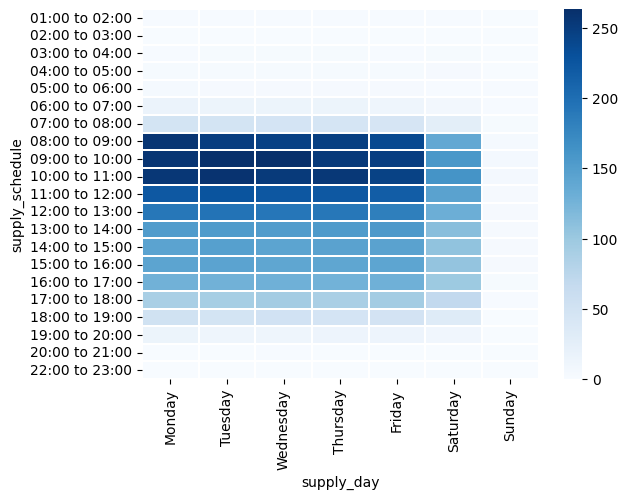

In [17]:
heatmap = temporal_analysis(df)

heatmap

In [18]:
########################## Type of Establishment vs Delivery Transportation Mode
def transportation_mode(df):

    # Keep relevant columns
    df = df[['economic_activity', 'supply_unloading', 'employees']]

    # Identify type of commerce
    est_types = ['Proveedor', 'Venta al detalle', 'Fabricante', 'Ventas por internet']
    df['est_type'] = df['economic_activity'].apply(lambda x: next((word for word in est_types if word.lower() in x.lower()), None))

    # Identify type of transportation mode
    transp_mode = ['camión', 'motocicleta', 'bicicleta', 'carreta', 'particular']
    df['transp_type'] = df['supply_unloading'].apply(lambda x: [word for word in transp_mode if word.lower() in x.lower()])
    
    # Explode transportation mode
    df = df.explode('transp_type').reset_index(drop=True)

    # Groupby to compute stacked bar plot
    df = df.groupby(['est_type', 'transp_type']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df.pivot(index='est_type', columns='transp_type', values='frequency').fillna(0)
    df = df.div(df.sum(axis=1), axis=0)

    # Rename columns and indexes
    rename = {'Proveedor': 'Supplier', 'Venta al detalle': 'Retailer', 'Fabricante': 'Manufacturer', 'Ventas por internet': 'E-commerce'}
    df.rename(index=rename, inplace=True)

    rename1 = {'bicicleta': 'Bicycle', 'camión': 'Truck', 'carreta': 'Handcart', 'motocicleta': 'Motorcycle', 'particular': 'Private Vehicle'}
    df.rename(columns=rename1, inplace=True)

    return df

########################## Type of Establishment vs Unloading Location
def unloading_location(df):

    # Keep relevant columns
    df = df[['economic_activity', 'supply_unloading', 'employees']]

    # Identify type of commerce
    est_types = ['Proveedor', 'Venta al detalle', 'Fabricante', 'Ventas por internet']
    df['est_type'] = df['economic_activity'].apply(lambda x: next((word for word in est_types if word.lower() in x.lower()), None))

    # Identify how is the unloading
    unloading = ['sobre la vía', 'sobre el andén', 'bahía', 'internamente', 'vías aledañas', 'parqueadero']
    df['unloading_location'] = df['supply_unloading'].apply(lambda x: [word for word in unloading if word.lower() in x.lower()])

    # Explode unloading location
    df = df.explode('unloading_location').reset_index(drop=True)

    # Groupby to compute stacked bar plot
    df = df.groupby(['est_type', 'unloading_location']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df.pivot(index='est_type', columns='unloading_location', values='frequency').fillna(0)
    df = df.div(df.sum(axis=1), axis=0)

    # Rename columns and indexes
    rename = {'Proveedor': 'Supplier', 'Venta al detalle': 'Retailer', 'Fabricante': 'Manufacturer', 'Ventas por internet': 'E-commerce'}
    df.rename(index=rename, inplace=True)

    rename1 = {'sobre la vía': 'On the road', 'sobre el andén': 'On the sidewalk', 'bahía': 'Loading/unloading zone',
               'internamente': 'Establishment facilities', 'vías aledañas': 'Nearby roads', 'parqueadero': 'Parking lot'}
    df.rename(columns=rename1, inplace=True)

    return df

########################## Type of Establishment vs Unloading Equipement
def unloading_equipement(df):

    # Keep relevant columns
    df = df[['economic_activity', 'warehouse_equipement', 'employees']]

    # Identify type of commerce
    est_types = ['Proveedor', 'Venta al detalle', 'Fabricante', 'Ventas por internet']
    df['est_type'] = df['economic_activity'].apply(lambda x: next((word for word in est_types if word.lower() in x.lower()), None))

    # Identify unloading equipement
    df['warehouse_equipement'] = df['warehouse_equipement'].str.strip()
    df['warehouse_equipement'] = df['warehouse_equipement'].str.replace(r".*ning.*", 'No', regex=True, case=False)

    # Explode warehouse equipement
    df['warehouse_equipement'] = df['warehouse_equipement'].str.split(',\s*')
    df = df.explode('warehouse_equipement')

    # Unify type of equipement
    to_unify = {'Caminata': 'Manual workforce', 'Na': 'No', '1': 'No', 'Camina': 'Manual workforce',
                'Parqueadero de uso interno': 'No', 'Al hombro': 'Manual workforce', 'Descargue a mano': 'Manual workforce',
                'no posee': 'No', 'Personal externo': 'Manual workforce', 'Parqueadero para clientes': 'No',
                'A mano': 'Manual workforce', 'La misma persona la carga en sus manos': 'Manual workforce',
                'No hay bodega': 'No', 'Las personas lo llevan cargados': 'Manual workforce',
                'No se requiere por el volumen': 'No', 'No aplica': 'No', 'No es necesario entra oaquete manual': 'No',
                'No se requiere lis paquetes vson pequeños sebtraen a mano': 'No', 'Caminando': 'Manual workforce',
                'Cajas': 'No', 'Carretilla entra': 'Carretilla', 'Bahía': 'No', np.nan: 'No', 'no': 'No',
                'Escaleras eléctricas': 'Other', 'Escalas': 'Other', 'Porta doble': 'Other', 'Montacargas': 'Loading Ramp',
                'Rampa mecánica': 'Loading Ramp', 'Gato hidráulico': 'Loading Ramp'}
    
    df['warehouse_equipement'] = df['warehouse_equipement'].replace(to_unify)

    

    # Groupby to compute stacked bar plot
    df = df.groupby(['est_type', 'warehouse_equipement']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df.pivot(index='est_type', columns='warehouse_equipement', values='frequency').fillna(0)
    df = df.div(df.sum(axis=1), axis=0)

    # Rename columns and indexes
    rename = {'Proveedor': 'Supplier', 'Venta al detalle': 'Retailer', 'Fabricante': 'Manufacturer', 'Ventas por internet': 'E-commerce'}
    df.rename(index=rename, inplace=True)

    rename1 = {'Carretilla': 'Handcart', 'No': 'None', 'Elevador': 'Elevator',
                 'Rampa fija': 'Fixed Loading Ramp'}
    df.rename(columns=rename1, inplace=True)

    return df 

########################## Type of Establishment vs Supply frequency
def supply_frequency(df):

    # Keep relevant columns
    df = df[['economic_activity', 'supply_week', 'employees']]

    # Identify type of commerce
    est_types = ['Proveedor', 'Venta al detalle', 'Fabricante', 'Ventas por internet']
    df['est_type'] = df['economic_activity'].apply(lambda x: next((word for word in est_types if word.lower() in x.lower()), None))

    # Change names
    to_unify = {'La periodicidad es quincenal': 'Other', 'La periodicidad es mensual': 'Other'}
    df['supply_week'] = df['supply_week'].replace(to_unify)

    # Groupby to compute stacked bar plot
    df = df.groupby(['est_type', 'supply_week']).count().rename(columns={'employees': 'frequency'}).reset_index()
    df = df.pivot(index='est_type', columns='supply_week', values='frequency').fillna(0)
    df = df.div(df.sum(axis=1), axis=0)

    # Rename columns and indexes
    rename = {'Proveedor': 'Supplier', 'Venta al detalle': 'Retailer', 'Fabricante': 'Manufacturer', 'Ventas por internet': 'E-commerce'}
    df.rename(index=rename, inplace=True)

    rename1 = {5: '5 times a week', '6 o más': '6 times or more a week', '1 vez por semana': '1 time a week',
               2: '2 times a week', 3: '3 times a week', 4: '4 times a week'}
    df.rename(columns=rename1, inplace=True)

    df = df[['1 time a week', '2 times a week', '3 times a week',
             '4 times a week', '5 times a week', '6 times or more a week', 'Other']]

    return df

<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\667909170.py:79: SyntaxWarning: invalid escape sequence '\s'
  df['warehouse_equipement'] = df['warehouse_equipement'].str.split(',\s*')


In [19]:
############################### 

def plots_type_of_establishments(data_dict):

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()

    for ax, (title, content) in zip(axes, data_dict.items()):
    
        proportions = content['data']
        legend_title = content.get('legend_title')

        # Plot
        colors = sns.color_palette("Greys", n_colors=len(proportions.columns))
        bottom = pd.Series([0]*len(proportions), index=proportions.index)

        for i, col in enumerate(proportions.columns):
            ax.bar(
                proportions.index,
                proportions[col],
                bottom=bottom,
                label=col,
                color=colors[i]
            )
            bottom += proportions[col]

            # Format plot
        ax.set_title(title, fontsize=22)
        #ax.set_xlabel("Establishment Type", fontsize=12)
        #ax.set_ylabel("Proportion", fontsize=12)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=14)
        ax.legend(title=legend_title, fontsize=14, title_fontsize=15, loc='upper right')

    fig.tight_layout()

    return fig

In [20]:
# Compute Stacked Bar Plots
transp_mode = transportation_mode(df)

unload_loca = unloading_location(df)

unload_equi = unloading_equipement(df)

supply_freq = supply_frequency(df)

# Data Dictionary
plot_dict = {'a) Supplier Transportation Mode': {'data': transp_mode, 'legend_title': 'Vehicle Type'},
             'b) Supplying Frequency': {'data': supply_freq, 'legend_title': 'Supply Frequency'},
             'c) Unloading Location': {'data': unload_loca, 'legend_title': 'Unloading Location'},
             'd) Unloading Equipment': {'data': unload_equi, 'legend_title': 'Unloading Equipment'}}

C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\667909170.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['est_type'] = df['economic_activity'].apply(lambda x: next((word for word in est_types if word.lower() in x.lower()), None))
C:\Users\cgranadamunoz\AppData\Local\Temp\ipykernel_26944\667909170.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transp_type'] = df['supply_unloading'].apply(lambda x: [word for word in transp_mode if word.lower() in x.lower()])
C:\Users\cgranadamunoz\

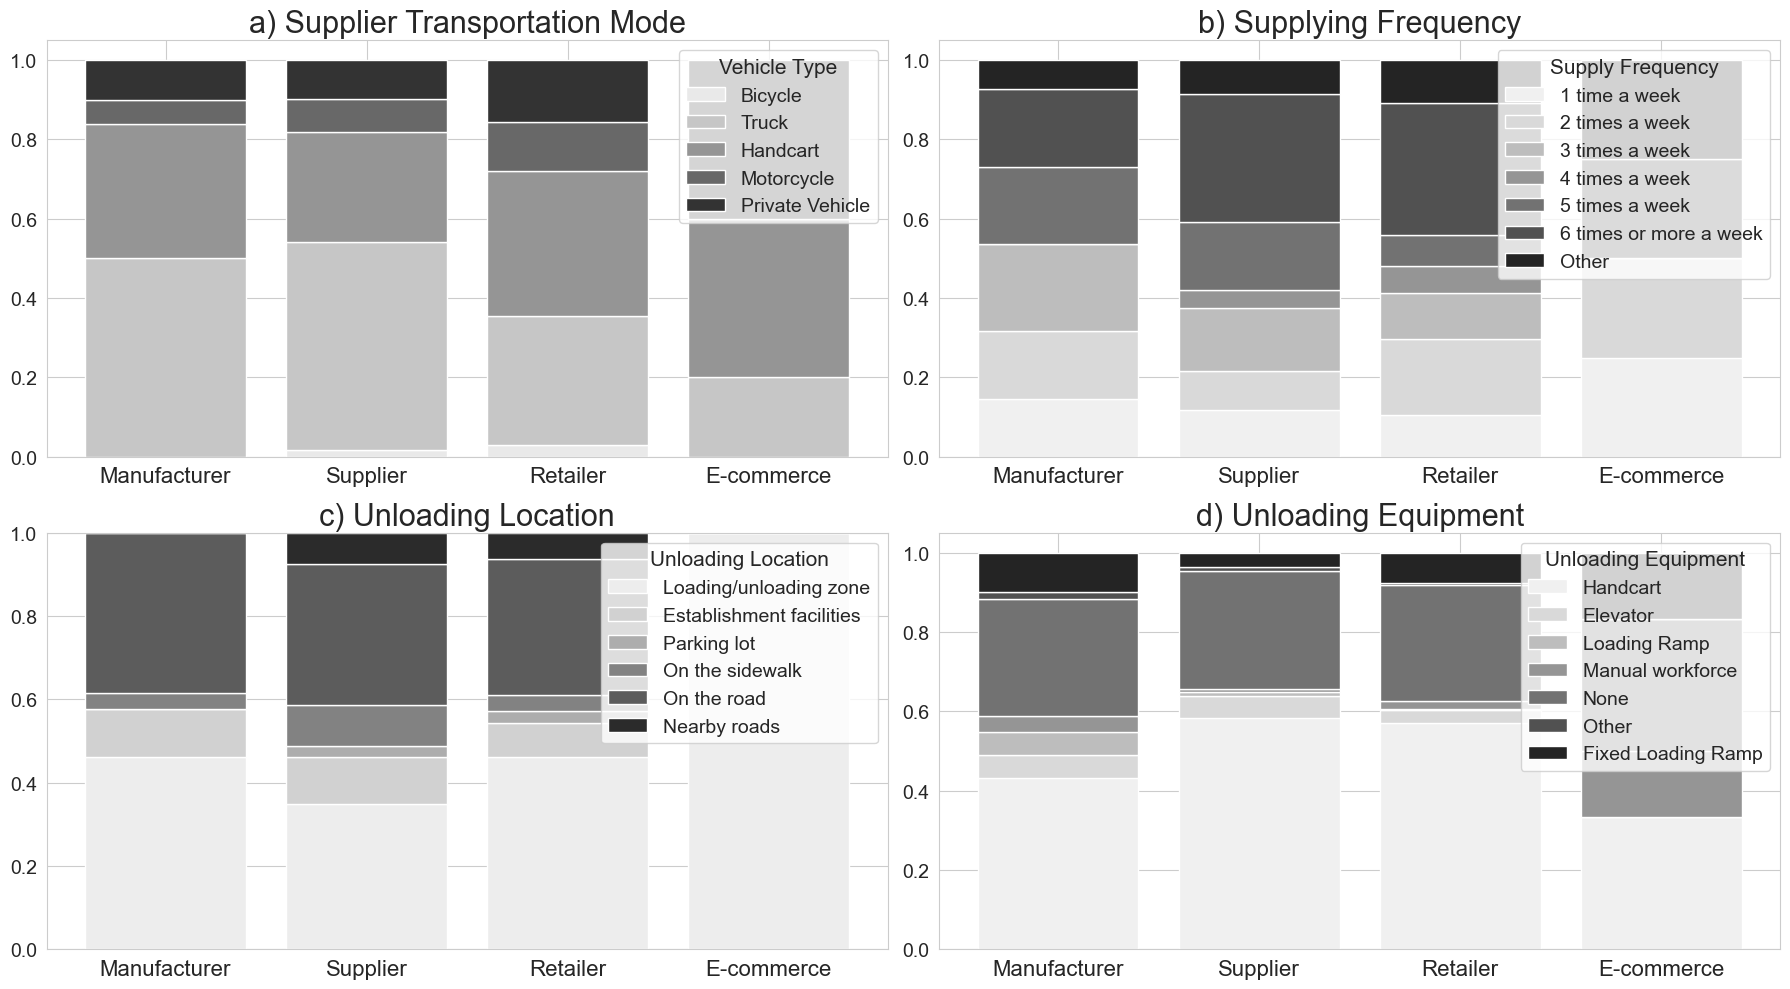

In [251]:
m = plots_type_of_establishments(plot_dict)

In [21]:
df['supply_unloading'].unique()

array(['En camión, estacionado en zona bahía y la ingresa la empresa transportadora, En carreta "zorrilla"',
       'En carreta "zorrilla"',
       'En camión, sobre la vía, En carreta "zorrilla"',
       'En camión, estacionado en zona bahía y la ingresa la empresa transportadora',
       'En camión, sobre la vía, En motocicleta',
       'En vehículo particular', 'En camión, se descarga internamente',
       'En camión, sobre la vía',
       'En camión, sobre la vía, En camión, sobre el andén',
       'En carreta "zorrilla", En vehículo particular', 'En motocicleta',
       'En camión, estacionado en bahía y la ingresa el personal de mi empresa, En carreta "zorrilla"',
       'En camión, estacionado en bahía y la ingresa el personal de mi empresa',
       'En camión, se descarga internamente, En motocicleta, En bicicleta, En carreta "zorrilla", En vehículo particular',
       'En camión, se descarga internamente, En motocicleta, En bicicleta, En carreta "zorrilla"',
       'En camión,

In [22]:
def warehouse_ownership(df):

    return

In [23]:
df['warehouse'].unique()

array(['Interno', 'No', 'Externo, propio', 'Externo, alquilado',
       'Externo, compartido con otros comercios'], dtype=object)

In [24]:
df['main_products'].unique()

array(['Cosméticos y productos de belleza', 'Calzado',
       'Reciclaje y residuos', 'Manufacturas', 'Mecánica',
       'Moda y textiles', 'Mensajería', 'Ferretería', 'Maderas',
       'Artículos para el hogar', 'Electrónica',
       'Juguetería y elementos deportivos',
       'Cacao, chocolate y confitería', 'Productos médicos y de salud',
       'Café', 'Restauración', 'Electrodomésticos', 'Papelería',
       'Productos alimenticios', 'Materiales de construcción',
       'Productos veterinarios y mascotas', 'Muebles de oficina',
       'Compraventa', 'Productos de aseo', 'Joyas',
       'Servicios financieros', 'Refrigeración', 'Maquinaria',
       'Servicios de telecomunicaciones', 'Productos cárnicos',
       'Arte y materiales para el arte', 'Bares y ocio',
       'Servicio de estacionamiento', 'Suministros'], dtype=object)

Plot a relative bar plot (Type of commerce vs Type of loading/Unloading tools; Type of commerce vs Main product)
Plot information regarding the warehouse
Plot the perception of safety regarding loading and unloading
Plot the frequency of supply